In [71]:
# Mount GDrive

from google.colab import drive
drive.mount('/content/drive')

# Do not forget to bring back the cutoff to 2024

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
################################
# Install additional libraries
################################

#!pip install optuna
#!pip install mlflow
#!pip install requests
#!pip install plotly
#!pip install folium
#!pip install streamlit
#!pip install sqlalchemy
#!pip install lightgbm
#!pip install fastapi
#!pip install mlforecast
#!pip install neuralforecast

!pip install tsfeatures
!pip install sklearn
!pip install xgboost
!pip install itertools
!pip install prophet
!pip install orbit
!pip install tabulate
!pip install seaborn
!pip install statsmodels
!pip install statsforecast

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [73]:
# Import necessary libraries

#import optuna
#import mlflow
#import requests
#import plotly
#import folium
#import streamlit
#import sqlalchemy
#from fastapi import FastAPI
#import orbit
#import lightgbm
#import tensorflow as tf
#import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tsfeatures import tsfeatures
import yaml, json
import sklearn
import itertools

from tabulate import tabulate
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from prophet import Prophet
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('ignore')


In [74]:
##########################################
# YAML Starting File Configuration
##########################################

# Kaggle Data Extraction
enable_kaggle_RSCM_data_extraction = True
save_kaggle_data_to_gdrive = True
cutoff_date = '2024-01-01'

#  Data Acquisition and Setting up
explore_dataframe = True

# Checking for Duplicates, Missing Values, and Unique Elements
checking_values = True
visualizing_values = True

# Dropping Duplicates, Filling Missing Values, Selection of Columns
data_preprocessing = True

# Understanding the Dataset
dataset_understanding = True
desired_cols = ['typhoon_grade','latitude','longitude','pressure','speed']

# Spatial Filtering for PAR
PAR_latitude = [5.,25.]
PAR_longitude = [115.,135.]
export_PAR_data = True

# Grouping Exploration
display_grouping = True

In [75]:
# Kaggle RSMC Data Extraction
if enable_kaggle_RSCM_data_extraction:
  # Kaggle Methodology based on KRYS

  #imports
  import requests
  import zipfile
  import os

  #define the URL and the file name
  file_url = 'https://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/Besttracks/bst_all.zip'
  file_name = 'bst_all.zip'

  #define the file path
  extract_path = r'/kaggle/working/'

  #downloading the file from JMA website
  response = requests.get(file_url)
  with open(file_name, 'wb') as file:
      file.write(response.content)

  #decompression of file
  with zipfile.ZipFile(file_name, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

  #delete the ZIP file
  os.remove(file_name)

  #the file path of decompressed txt file
  file_path = r'/kaggle/working/bst_all.txt'

  #read the number of lines(including hearder(s))
  line_count = 0
  header_line_count = 0
  with open(file_path,'r') as file:
      for line in file:
          line_count += 1
          if line.startswith("66666"):
              header_line_count += 1
  print('Total lines of data: ', line_count, ' line(s)\n')

  #print the headers of each recorded data
  print('Total lines for Each Tropical Cyclone: ',header_line_count, ' line(s)\n')

  #open the file and read the first 10 lines
  with open(file_path, 'r', encoding='utf-8') as file:
      first_10_lines = [next(file) for _ in range(10)]

  #divider
  print('-------------------------------')

  #print out first 10 lines
  print('\nFirst 10 lines:\n')
  for line in first_10_lines:
      print(line, end='')

  import csv

  # read TXT file
  with open(r'/kaggle/working/bst_all.txt', 'r') as txt_file:
      lines = txt_file.readlines()
  count = 0
  # create a CSV file and write it
  with open(r'/kaggle/working/data_head0.csv', 'w', newline='') as csv_file:
      csv_writer = csv.writer(csv_file)
      # column names,according to the JMA format explaination
      csv_writer.writerow(['Indicator', 'International number ID 1', 'Number of data lines',
                          'Tropical cyclone number ID', 'International number ID 2','Flag of the last data line',
                          'Difference between the time of the last data and the time of the final analysis',
                          'Name of the storm', 'Date of the latest revision'])

      # Find the lines that start with 66666 which is the indicator of Header Lines
      for line in lines:
          if line.startswith('66666'):
              try:
                  # according to the index numbers provided by JMA.
                  Indicator = line[0:5]
                  International_number_ID = line[6:10]
                  Number_of_data_lines = line[12:15]
                  Tropical_cyclone_number_ID = line[16:20]
                  International_number_ID2 = line[21:25]
                  Flag_of_last_data_line = line[26]
                  Difference = line[28]
                  Name_of_the_storm = line[30:50]
                  Date_of_latest_revision = line[64:72]

                  X = int(line[12:15])  #number of data lines and duplicate the line
                  for _ in range(X):
                      csv_writer.writerow([Indicator, International_number_ID, Number_of_data_lines,
                                          Tropical_cyclone_number_ID, International_number_ID2,
                                          Flag_of_last_data_line, Difference,
                                          Name_of_the_storm.strip(), Date_of_latest_revision.strip()])
              except (ValueError, IndexError):
                  pass

  print("Extracted and Saved as data_head0.csv!")

  data_head0 = pd.read_csv(r'/kaggle/working/data_head0.csv')
  data_head0.sample(5)

  input_file_path = r'/kaggle/working/bst_all.txt'
  output_file_path = r'/kaggle/working/data_no_headers.txt'

  try:
      with open(input_file_path, 'r', encoding='utf-8') as input_file:
          lines = input_file.readlines()

      filtered_lines = [line for line in lines if not line.startswith('66666')]

      with open(output_file_path, 'w', encoding='utf-8') as output_file:
          output_file.writelines(filtered_lines)

      result = len(filtered_lines)
      print(f"Deleted the lines start with '66666'，Saved to {output_file_path}, it has {result} lines")
  except FileNotFoundError:
      print("File does not exist!")
  except Exception as e:
      print(f"Error：{str(e)}")
      print("Failed!")

  # read the previous txt file that has only lines with no header lines
  with open(r'/kaggle/working/data_no_headers.txt', 'r') as new_txt_file:
      new_lines = new_txt_file.readlines()

  # create a new CSV file to record the data lines data
  with open(r'/kaggle/working/data_dataLines0.csv', 'w', newline='') as new_csv_file:
      csv_writer = csv.writer(new_csv_file)

      # column names, according to the explaination provided by JMA.
      csv_writer.writerow(['Time of analysis', 'Indicator', 'Grade', 'Latitude of the center',
                          'Longitude of the center', 'Central pressure', 'Maximum sustained wind speed',
                          'Direction of the longest radius of 50kt winds or greater',
                          'The longest radius of 50kt winds or greater',
                          'The shortest radius of 50kt winds or greater',
                          'Direction of the longest radius of 30kt winds or greater',
                          'The longest radius of 30kt winds or greater',
                          'The shortest radius of 30kt winds or greater',
                          'Indicator of landfall or passage'])

      for line in new_lines:
          # according to the index numbers provided by JMA.
          Time_of_analysis = line[0:8]
          Indicator = line[9:12]
          Grade = line[13]
          Latitude_of_the_center = line[15:18]
          Longitude_of_the_center = line[19:23]
          Central_pressure = line[24:28]
          Maximum_sustained_wind_speed = line[33:36]
          Direction_of_the_longest_radius_of_50kt_winds_or_greater = line[41]
          The_longest_radius_of_50kt_winds_or_greater = line[42:46]
          The_shortest_radius_of_50kt_winds_or_greater = line[47:51]
          Direction_of_the_longest_radius_of_30kt_winds_or_greater = line[52]
          The_longest_radius_of_30kt_winds_or_greater = line[53:57]
          The_shortest_radius_of_30kt_winds_or_greater = line[58:62]
          Indicator_of_landfall_or_passage = line[71]

          csv_writer.writerow([Time_of_analysis, Indicator, Grade, Latitude_of_the_center,
                              Longitude_of_the_center, Central_pressure, Maximum_sustained_wind_speed,
                              Direction_of_the_longest_radius_of_50kt_winds_or_greater,
                              The_longest_radius_of_50kt_winds_or_greater,
                              The_shortest_radius_of_50kt_winds_or_greater,
                              Direction_of_the_longest_radius_of_30kt_winds_or_greater,
                              The_longest_radius_of_30kt_winds_or_greater,
                              The_shortest_radius_of_30kt_winds_or_greater,
                              Indicator_of_landfall_or_passage
                              ])

  print("Extracted and Saved as data_dataLines0.csv!")

  data_dataLines0 = pd.read_csv(r'/kaggle/working/data_dataLines0.csv')
  data_dataLines0.sample(5)

  # header lines
  csv1 = pd.read_csv(r'/kaggle/working/data_head0.csv')

  # data lines
  csv2 = pd.read_csv(r'/kaggle/working/data_dataLines0.csv')

  # make sure their have same number of rows
  if len(csv1) != len(csv2):
      raise ValueError("the number of rows is not matched!")

  # merge them together and put data lines part on the right side of header lines.
  merged_csv = pd.concat([csv1, csv2], axis=1)

  # merged and put them into a new file.
  merged_csv.to_csv(r'/kaggle/working/data_header_data_merged.csv', index=False)

  merged_csv.sample(5)

  df = pd.read_csv(r'/kaggle/working/data_header_data_merged.csv')

  df_copy = df.copy()
  # drop the mentioned columns
  df_copy = df_copy.drop(['Indicator', 'Number of data lines', 'International number ID 2',
                          'Flag of the last data line', 'Tropical cyclone number ID',
                          'Difference between the time of the last data and the time of the final analysis',
                          'Date of the latest revision', 'Indicator.1'], axis = 1)
  df_copy = df_copy.rename(columns = {"International number ID 1": "International number ID"})
  df_copy.sample(5)

  # convert time
  def convert_to_datetime(num):
      # fill up the numbers that in years 2000+, because they are lack of 1 digit at the front, just simply fill up with 1 digit of 0.
      num_str = str(num).zfill(8)

      # according to the format, extract the number
      year = int(num_str[:2])
      month = int(num_str[2:4])
      day = int(num_str[4:6])
      hour = int(num_str[6:])

      # since the first recorded data is from 1951, then we choose 51 as the pivot.
      if year < 51:
          year += 2000
      else:
          year += 1900


      return pd.Timestamp(year=year, month=month, day=day,hour=hour)
  # update to the file
  df_copy['Time of analysis'] = df_copy['Time of analysis'].apply(convert_to_datetime)


  df_copy.sample(5)
  c = df_copy.select_dtypes(include=[object]).columns
  df_copy[c] = df_copy[c].astype('string')
  df_copy.to_csv(r'/kaggle/working/modified_data.csv', index = False)
  data_types = df_copy.dtypes

  # print every data type
  for column_name, data_type in data_types.items():
      print(f"Column '{column_name}' has data type: {data_type}")
  import numpy as np
  cols_to_convert = ['Maximum sustained wind speed',
                    'The longest radius of 50kt winds or greater',
                    'The shortest radius of 50kt winds or greater',
                    'The longest radius of 30kt winds or greater',
                    'The shortest radius of 30kt winds or greater'
                    ]

  # convert into integer
  def convert_to_int(value):
      try:
          return int(value)
      except ValueError:
          return np.nan  # put it as NaN

  for col in cols_to_convert:
      df_copy[col] = df_copy[col].apply(convert_to_int)
  df_copy['Grade'] = df_copy['Grade'].astype(str)
  data_types = df_copy.dtypes

  for column_name, data_type in data_types.items():
      print(f"Column '{column_name}' has data type: {data_type}")
  df_copy.sample(5)

  column_name = 'Grade'

  # Explaination from JMA
  mapping_dict = {
      '1': 'Not used',
      '2': 'Tropical Depression (TD)',
      '3': 'Tropical Storm (TS)',
      '4': 'Severe Tropical Storm (STS)',
      '5': 'Typhoon (TY)',
      '6': 'Extra-tropical Cyclone (L)',
      '7': 'Just entering into the responsible area of RSMC Tokyo-Typhoon Center',
      '8': 'Not used',
      '9': 'Tropical Cyclone of TS intensity or higher',
  }


  df_copy[column_name] = df_copy[column_name].map(mapping_dict)
  df_copy.sample(5)

  column_name = 'Direction of the longest radius of 50kt winds or greater'


  mapping_dict = {
      '0': 'No direction (Longest radius of 50kt winds is 0)',
      '1': 'Northeast (NE)',
      '2': 'East (E)',
      '3': 'Southeast (SE)',
      '4': 'South (S)',
      '5': 'Southwest (SW)',
      '6': 'West (W)',
      '7': 'Northwest (NW)',
      '8': 'North (N)',
      '9': '(symmetric circle)',
  }


  df_copy[column_name] = df_copy[column_name].map(mapping_dict)
  df_copy.sample(5)

  column_name = 'Direction of the longest radius of 30kt winds or greater'


  mapping_dict = {
      '0': 'No direction (Longest radius of 50kt winds is 0)',
      '1': 'Northeast (NE)',
      '2': 'East (E)',
      '3': 'Southeast (SE)',
      '4': 'South (S)',
      '5': 'Southwest (SW)',
      '6': 'West (W)',
      '7': 'Northwest (NW)',
      '8': 'North (N)',
      '9': '(symmetric circle)',
  }


  df_copy[column_name] = df_copy[column_name].map(mapping_dict)
  df_copy.sample(5)

  df_copy['Latitude of the center'] = df_copy['Latitude of the center'] / 10
  df_copy['Longitude of the center'] = df_copy['Longitude of the center'] / 10

  df_copy.to_csv(r'/kaggle/working/RSMC_Best_Track_Data.csv', index = False)

  print(df_copy.head())




Total lines of data:  72141  line(s)

Total lines for Each Tropical Cyclone:  1924  line(s)

-------------------------------

First 10 lines:

66666 5101   10      5101 0 6                                   19901017        
51021906 002 2 200 1385 1010                                                    
51021912 002 2 200 1385 1010                                                    
51021918 002 2 230 1421 1000                                                    
51022000 002 9 250 1460  994                                                    
51022006 002 9 276 1506  994                                                    
51022012 002 9 289 1533  994                                                    
51022018 002 9 313 1575  992                                                    
51022100 002 9 326 1621  990                                                    
51022106 002 6 339 1660  990                                                    
Extracted and Saved as data_head0.csv!
Deleted 

In [76]:
# Convert the Kaggle Extracted Data to the Given Format

# Load the Kaggle Dataset
kaggle_typhoon_ds = pd.read_csv('/kaggle/working/RSMC_Best_Track_Data.csv')

# Save it to my GDrive
if save_kaggle_data_to_gdrive:
  kaggle_typhoon_ds.to_csv('/content/drive/MyDrive/Colab Notebooks/RSMC_Data/RSMC_Best_Track_Data.csv')

# Reorder columns (For TSF)
kaggle_typhoon_ds_cols = kaggle_typhoon_ds.columns.tolist()
col_order = [0,2,1,3] + np.arange(4,len(kaggle_typhoon_ds_cols)).astype(int).tolist()
kaggle_typhoon_ds_cols_reordered = np.array(kaggle_typhoon_ds_cols)[col_order].tolist()
kaggle_typhoon_ds = kaggle_typhoon_ds[kaggle_typhoon_ds_cols_reordered]

# Rename columns
kaggle_typhoon_ds.columns = ['international_id','date_time','storm_name','typhoon_grade','latitude','longitude','pressure','speed', 'long_radius50_direction', 'long_radius50', 'short_radius50','long_radius30_direction','long_radius30','short_radius30','japan_fallpass']

# Convert the typhoon_grade to number
kaggle_typhoon_TG = kaggle_typhoon_ds['typhoon_grade'].unique()
kaggle_typhoon_TG_dict = {'Tropical Depression (TD)':2,'Tropical Storm (TS)':3,'Severe Tropical Storm (STS)':4,'Typhoon (TY)':5,'Extra-tropical Cyclone (L)':6,'Just entering into the responsible area of RSMC Tokyo-Typhoon Center':7,'Tropical Cyclone of TS intensity or higher':9}
kaggle_typhoon_ds['typhoon_grade'] = kaggle_typhoon_ds['typhoon_grade'].map(kaggle_typhoon_TG_dict)

# Cut-off to the desired end year
kaggle_typhoon_ds = kaggle_typhoon_ds[kaggle_typhoon_ds['date_time'] < cutoff_date]

print(tabulate(kaggle_typhoon_ds.tail(5), headers='keys', tablefmt='psql'))
print(f'Shape of the kaggle typhoon ds: {kaggle_typhoon_ds.shape}')

if save_kaggle_data_to_gdrive:
  kaggle_typhoon_ds.to_csv('/content/drive/MyDrive/Colab Notebooks/RSMC_Data/Typhoon_Dataset_1951_2020.csv')


+-------+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+--------------------------------------------------+-----------------+------------------+---------------------------+-----------------+------------------+------------------+
|       |   international_id | date_time           | storm_name   |   typhoon_grade |   latitude |   longitude |   pressure |   speed | long_radius50_direction                          |   long_radius50 |   short_radius50 | long_radius30_direction   |   long_radius30 |   short_radius30 | japan_fallpass   |
|-------+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+--------------------------------------------------+-----------------+------------------+---------------------------+-----------------+------------------+------------------|
| 69298 |               2317 | 2023-12-17 06:00:00 | JELAWAT      |         

In [77]:
##########################################
# Data Acquisition and Setting up
##########################################

# Data loading and initial inspection
typhoon_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RSMC_Data/Typhoon_Dataset_1951_2020.csv')
typhoon_metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RSMC_Data/Typhoon Metadata.csv')

# drop extra index column
typhoon_dataset = typhoon_dataset.drop(columns=['Unnamed: 0'])

# Basic Information on the Typhoon DataFrame
if explore_dataframe:
  print('=-'*25)
  print(f'Dataframe First 5 rows')
  print(tabulate(typhoon_dataset.head(5), headers='keys', tablefmt='psql'))
  print('=-'*25)
  print(f'Dataframe Last 5 rows')
  print(tabulate(typhoon_dataset.tail(5), headers='keys', tablefmt='psql'))
  print('=-'*25)
  print(tabulate(typhoon_dataset.info(), headers='keys', tablefmt='psql'))
  print('=-'*25)
  print(tabulate(typhoon_dataset.describe(), headers='keys', tablefmt='psql'))
  print('=-'*25)
  print(f'Column labels: {typhoon_dataset.columns}')
  print('=-'*25)
  print(f'Shape of the dataframe: {typhoon_dataset.shape}')
  print('=-'*25)
  print(f'Datatypes per column: {typhoon_dataset.dtypes}')
  print('=-'*25)



=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Dataframe First 5 rows
+----+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+---------------------------+-----------------+------------------+---------------------------+-----------------+------------------+------------------+
|    |   international_id | date_time           |   storm_name |   typhoon_grade |   latitude |   longitude |   pressure |   speed |   long_radius50_direction |   long_radius50 |   short_radius50 |   long_radius30_direction |   long_radius30 |   short_radius30 | japan_fallpass   |
|----+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+---------------------------+-----------------+------------------+---------------------------+-----------------+------------------+------------------|
|  0 |               5101 | 1951-02-19 06:00:00 |          nan |               2

DataFrame null count: 
 international_id               0
date_time                      0
storm_name                  1777
typhoon_grade                  0
latitude                       0
longitude                      0
pressure                       0
speed                      25267
long_radius50_direction    41614
long_radius50              41614
short_radius50             41614
long_radius30_direction    41614
long_radius30              41614
short_radius30             41614
japan_fallpass                 0
dtype: int64
DataFrame duplicate count: 0
Number of unique values: 
 international_id            1898
date_time                  47714
storm_name                   498
typhoon_grade                  7
latitude                     604
longitude                    876
pressure                     125
speed                         22
long_radius50_direction       10
long_radius50                 42
short_radius50                35
long_radius30_direction        9
long_radius30   

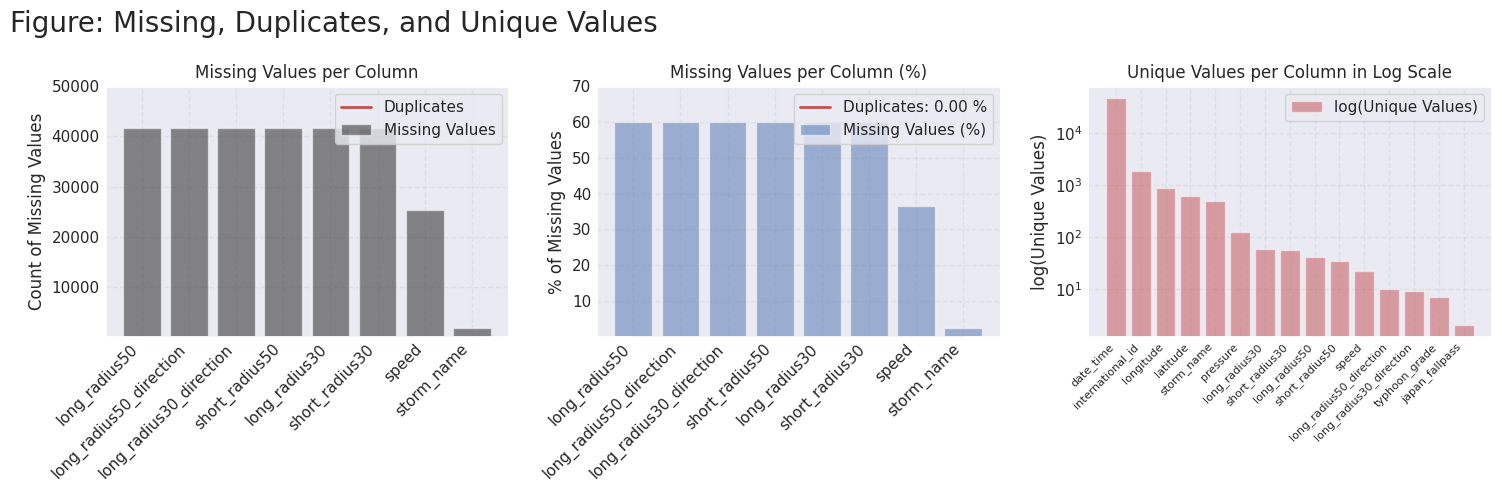

In [78]:
###############################################################
# Checking for Duplicates, Missing Values, and Unique Elements
###############################################################

# Missing Values
missVal = typhoon_dataset.isnull().sum()
missVal_sorted_nonzeros = missVal[missVal > 0].sort_values(ascending=False)

# Duplicates
dupCount = typhoon_dataset.duplicated().sum()

# Unique Values
uniqueVal = typhoon_dataset.nunique()
uniqueVal_sorted_nonzeros = uniqueVal[uniqueVal > 0].sort_values(ascending=False)

# Checking and Visualizing DataFrame Values
if checking_values:
  print(f'DataFrame null count: \n {missVal}')
  print('=============================')
  print(f'DataFrame duplicate count: {dupCount}')
  print('=============================')
  print(f'Number of unique values: \n {uniqueVal}')
  print('=============================')

if visualizing_values:
  # Creating a plot for missing values, duplicates, and number of unique items
  # I have used matplotlib to show some control in how I create my plots, later, seaborn-based plots will be implemented

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle('Figure: Missing, Duplicates, and Unique Values', fontsize=20, ha= 'left', x=0 )

  # Plot for Missing Values
  axes[0].bar(missVal_sorted_nonzeros.index, missVal_sorted_nonzeros.values, color = 'k', alpha = 0.5)
  axes[0].plot(missVal_sorted_nonzeros.index, [dupCount for i in range(len(missVal_sorted_nonzeros.index))], color = 'r', linewidth = 2, linestyle = '-')
  axes[0].set_title('Missing Values per Column')
  axes[0].set_ylabel('Count of Missing Values')
  axes[0].tick_params(axis = 'x', rotation = 45)
  for label in axes[0].get_xticklabels():
    label.set_ha('right')
  axes[0].locator_params(axis = 'y', nbins = 7)
  yticks = axes[0].get_yticks()
  yticks = yticks[yticks != 0]
  axes[0].set_yticks(yticks)
  axes[0].tick_params(axis='both', direction = 'in')
  for spine in axes[0].spines.values():
    spine.set_linewidth(2)
  axes[0].grid(True, linestyle = '--', color = 'gray', alpha = 0.1)
  axes[0].legend(['Duplicates', 'Missing Values'])

  # Plot for Missing Values in Percentage
  axes[1].bar(missVal_sorted_nonzeros.index, (missVal_sorted_nonzeros.values/typhoon_dataset.shape[0])*100, color = 'b', alpha = 0.5, label=f'Missing Values (%)')
  axes[1].plot(missVal_sorted_nonzeros.index, [(dupCount/typhoon_dataset.shape[0]*100) for i in range(len(missVal_sorted_nonzeros.index))], color = 'r', linewidth = 2, linestyle = '-', label = f'Duplicates: {(dupCount/typhoon_dataset.shape[0]*100):.2f} %')
  axes[1].set_title('Missing Values per Column (%)')
  axes[1].set_ylabel('% of Missing Values')
  axes[1].tick_params(axis = 'x', rotation = 45)
  for label in axes[1].get_xticklabels():
    label.set_ha('right')
  axes[1].locator_params(axis = 'y', nbins = 7)
  yticks = axes[1].get_yticks()
  yticks = yticks[yticks != 0]
  axes[1].set_yticks(yticks)
  axes[1].legend()
  axes[1].tick_params(axis='both', direction = 'in')
  for spine in axes[1].spines.values():
    spine.set_linewidth(2)
  axes[1].grid(True, linestyle = '--', color = 'gray', alpha= 0.1)

  # Plot for Number of Unique values
  axes[2].bar(uniqueVal_sorted_nonzeros.index, uniqueVal_sorted_nonzeros.values, color= 'r', alpha = 0.5)
  axes[2].set_title('Unique Values per Column in Log Scale')
  axes[2].set_ylabel('log(Unique Values)')
  axes[2].tick_params(axis = 'x', rotation = 45)
  for label in axes[2].get_xticklabels():
    label.set_ha('right')
  axes[2].locator_params(axis = 'y', nbins = 7)
  yticks = axes[2].get_yticks()
  yticks = yticks[yticks != 0]
  axes[2].set_yticks(yticks)
  axes[2].set_yscale('log')
  axes[2].tick_params(axis='both', direction = 'in')
  axes[2].tick_params(axis ='x', labelsize = 8)
  axes[2].grid(True, linestyle = '--', color = 'gray',alpha =0.1)
  axes[2].legend(['log(Unique Values)'])

  for spine in axes[2].spines.values():
    spine.set_linewidth(2)

  plt.tight_layout()
  plt.savefig('Data_Cleaning.png', dpi=300)
  print('Figure saved as Data_Cleaning.png')
  plt.show()


In [79]:
#########################################################################
# Dropping Duplicates, Filling Missing Values, Selection of Columns
#########################################################################

# Create a dataframe copy
typData_copy = typhoon_dataset.copy()

# Drop Duplicates
dropDup = typData_copy.drop_duplicates()

# Fill NA values
fillData = dropDup.fillna(0)

# Create another copy
typData_tidy = fillData.copy()

if data_preprocessing:
  print('----------------------------------')
  if (typData_tidy.isnull().sum() == 0).all().all():
    print(f'CHECKING - Total number of null values in all columns: 0')
  else:
    print(f'CHECKING - Total number of null values: {typData_tidy.isnull().sum()}')
  print('----------------------------------')
  print(f'CHECKING - Total number of duplicates in cleaned dataframe: {typData_tidy.duplicated().sum()}')
  print('=============================')
  print(tabulate(typData_tidy.head(3), headers='keys', tablefmt='psql'))
  print('=============================')
  print(tabulate(typData_tidy.tail(3), headers='keys', tablefmt='psql'))


----------------------------------
CHECKING - Total number of null values in all columns: 0
----------------------------------
CHECKING - Total number of duplicates in cleaned dataframe: 0
+----+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+---------------------------+-----------------+------------------+---------------------------+-----------------+------------------+------------------+
|    |   international_id | date_time           |   storm_name |   typhoon_grade |   latitude |   longitude |   pressure |   speed |   long_radius50_direction |   long_radius50 |   short_radius50 |   long_radius30_direction |   long_radius30 |   short_radius30 | japan_fallpass   |
|----+--------------------+---------------------+--------------+-----------------+------------+-------------+------------+---------+---------------------------+-----------------+------------------+---------------------------+-----------------+----

typhoon_grade
2    19157
3     9444
4     7019
5    11207
6     8121
7       33
9    14322
Name: count, dtype: int64
latitude
1.4     1
1.5     4
1.6     1
1.7     1
1.8     2
       ..
62.1    1
62.8    1
63.0    4
65.5    1
69.0    1
Name: count, Length: 604, dtype: int64
longitude
95.0     1
96.3     1
96.9     1
97.5     2
98.0     5
        ..
185.5    1
186.0    2
187.0    4
187.4    1
188.0    1
Name: count, Length: 876, dtype: int64
pressure
870      1
875      3
877      2
878      2
880      5
        ..
1015     2
1016    50
1018    17
1020     3
1022     1
Name: count, Length: 125, dtype: int64
speed
0.0      41614
35.0      3293
40.0      3121
45.0      3036
50.0      2746
55.0      2218
60.0      2058
65.0      1739
70.0      1972
75.0      1644
80.0      1609
85.0      1291
90.0      1034
95.0       680
100.0      631
105.0      243
110.0      237
115.0       79
120.0       45
125.0        9
130.0        3
140.0        1
Name: count, dtype: int64
Entry_Data_Distribution.

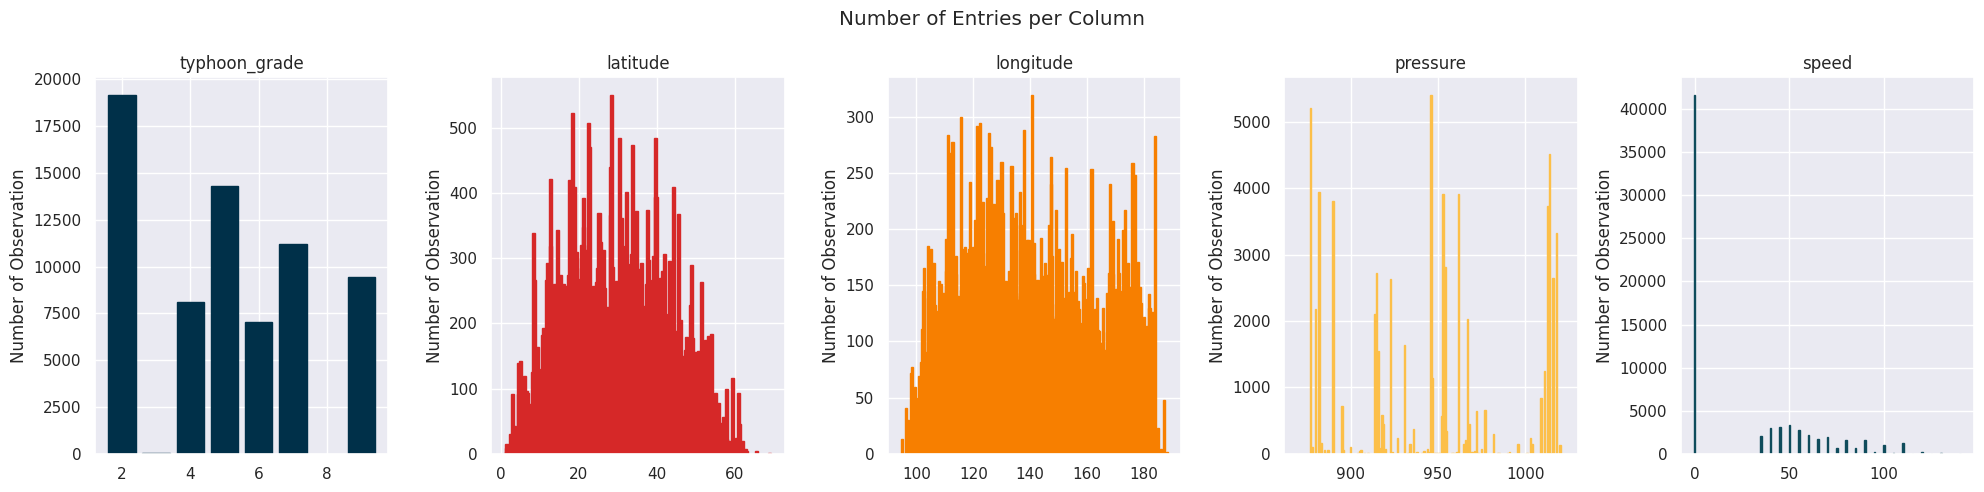

In [80]:
#########################################################################
# Dataset Understanding
#########################################################################

if dataset_understanding:
  for col in desired_cols:
    print(typData_tidy[col].value_counts().sort_index())
    print('=============================')

sns.set_style("darkgrid")
c_palette = ['#003049','#D62828','#F77F00','#FCBF49','#0F4C5C','#EAE2B7']
# Visualize Entry Distribution
fig, axes = plt.subplots(nrows = 1, ncols = len(desired_cols), figsize = (20, 5))

for i, col in enumerate(desired_cols):
  axes[i].bar(typData_tidy[col].unique(),typData_tidy[col].value_counts().sort_index(),color = c_palette[i],edgecolor =c_palette[i])
  axes[i].set_xlabel("")
  axes[i].set_ylabel("Number of Observation")
  axes[i].set_title(col)

fig.suptitle("Number of Entries per Column")
fig.savefig('Entry_Data_Distribution.png')
fig.tight_layout()
fig.show()

print('Entry_Data_Distribution.png has been saved')

In [81]:
################################################################################
# Spatial Filtering for PAR
################################################################################

# Notes:
# Set the typData_tidy as All Typhoon Dataset
# Create a PAR dataset - use SQL join, or pandas joining methods
# Convert dates using pd.to_datetime
# Focus on the count of typhoons within PAR - primary
# Add other factors for later and additional analytics

# Create another copy for typData_tidy
typData_tidy_copy = typData_tidy.copy()

# Set the area filter for the PAR in degrees
# set as YAML parameter
PAR_lat = PAR_latitude
PAR_long = PAR_longitude

# Set the area filter for the RSMC Tokyo Center Area Coverage
RSMC_lat = (typData_tidy_copy['latitude'].min(),typData_tidy_copy['latitude'].max())
RSMC_long = (typData_tidy_copy['longitude'].min(),typData_tidy_copy['longitude'].max())

# Print the ranges
print(f'PAR Latitude: {PAR_lat}, PAR Longitude: {PAR_long}')
print(f'RSMC Latitude: {RSMC_lat}, RSMC Longitude: {RSMC_long}')

# Add a two columns: Within PAR Latitude Range (True, False), and Within PAR Longitude Range (True, False)
typData_tidy_copy['within_PAR_lat'] = typData_tidy_copy['latitude'].apply(lambda x: True if (x >= PAR_lat[0]) and (x <= PAR_lat[1]) else False)
typData_tidy_copy['within_PAR_long'] = typData_tidy_copy['longitude'].apply(lambda x: True if (x >= PAR_long[0]) and (x <= PAR_long[1]) else False)

# RSMC Spliced Dataset for PAR

# Assumptions:
# The typhoon, upon reporting, can be outside or inside of PAR.
# Most Typhoons move from right to left relative to the Philippines
# Considered Typhoons that can affect PH are those entered the 135 deg East longitude or/and passes the 5 deg latitude
# Check for traced path for Fujiwara effect records, where typhoon can also go back due to consecutive typhoon occurrence within PAR

# Create an id filter - select the rows where both within_PAR_lat and within_PAR_long are true
typData_tidy_copy_id_filter = typData_tidy_copy[typData_tidy_copy['within_PAR_lat'] & typData_tidy_copy['within_PAR_long']]

# Filter the typData_tidy using the international_id - Typhoons within PAR
typPAR = typData_tidy_copy[typData_tidy_copy['international_id'].isin(typData_tidy_copy_id_filter['international_id'])]

# Creating a new table for Time Series EDA
typPAR = typPAR[['date_time','international_id','typhoon_grade','pressure','speed']]

# Convert to datetime
typPAR['datetime'] = pd.to_datetime(typPAR['date_time'])
typPAR.set_index('datetime', inplace=True)
typPAR.drop(columns=['date_time'],inplace = True)
print(tabulate(typPAR.head(10), headers='keys', tablefmt='psql'))

# Export this data
if export_PAR_data:
  typPAR.to_csv('/content/drive/MyDrive/Colab Notebooks/RSMC_Data/typPAR_data.csv')
  print(f'typPAR_data has been exported sucessfully')


PAR Latitude: [5.0, 25.0], PAR Longitude: [115.0, 135.0]
RSMC Latitude: (1.4, 69.0), RSMC Longitude: (95.0, 188.0)
+---------------------+--------------------+-----------------+------------+---------+
| datetime            |   international_id |   typhoon_grade |   pressure |   speed |
|---------------------+--------------------+-----------------+------------+---------|
| 1951-04-15 00:00:00 |               5103 |               2 |       1002 |       0 |
| 1951-04-15 06:00:00 |               5103 |               2 |       1002 |       0 |
| 1951-04-15 12:00:00 |               5103 |               2 |       1002 |       0 |
| 1951-04-15 18:00:00 |               5103 |               2 |       1000 |       0 |
| 1951-04-16 00:00:00 |               5103 |               2 |       1000 |       0 |
| 1951-04-16 06:00:00 |               5103 |               2 |       1000 |       0 |
| 1951-04-16 12:00:00 |               5103 |               2 |       1000 |       0 |
| 1951-04-16 18:00:00 |  

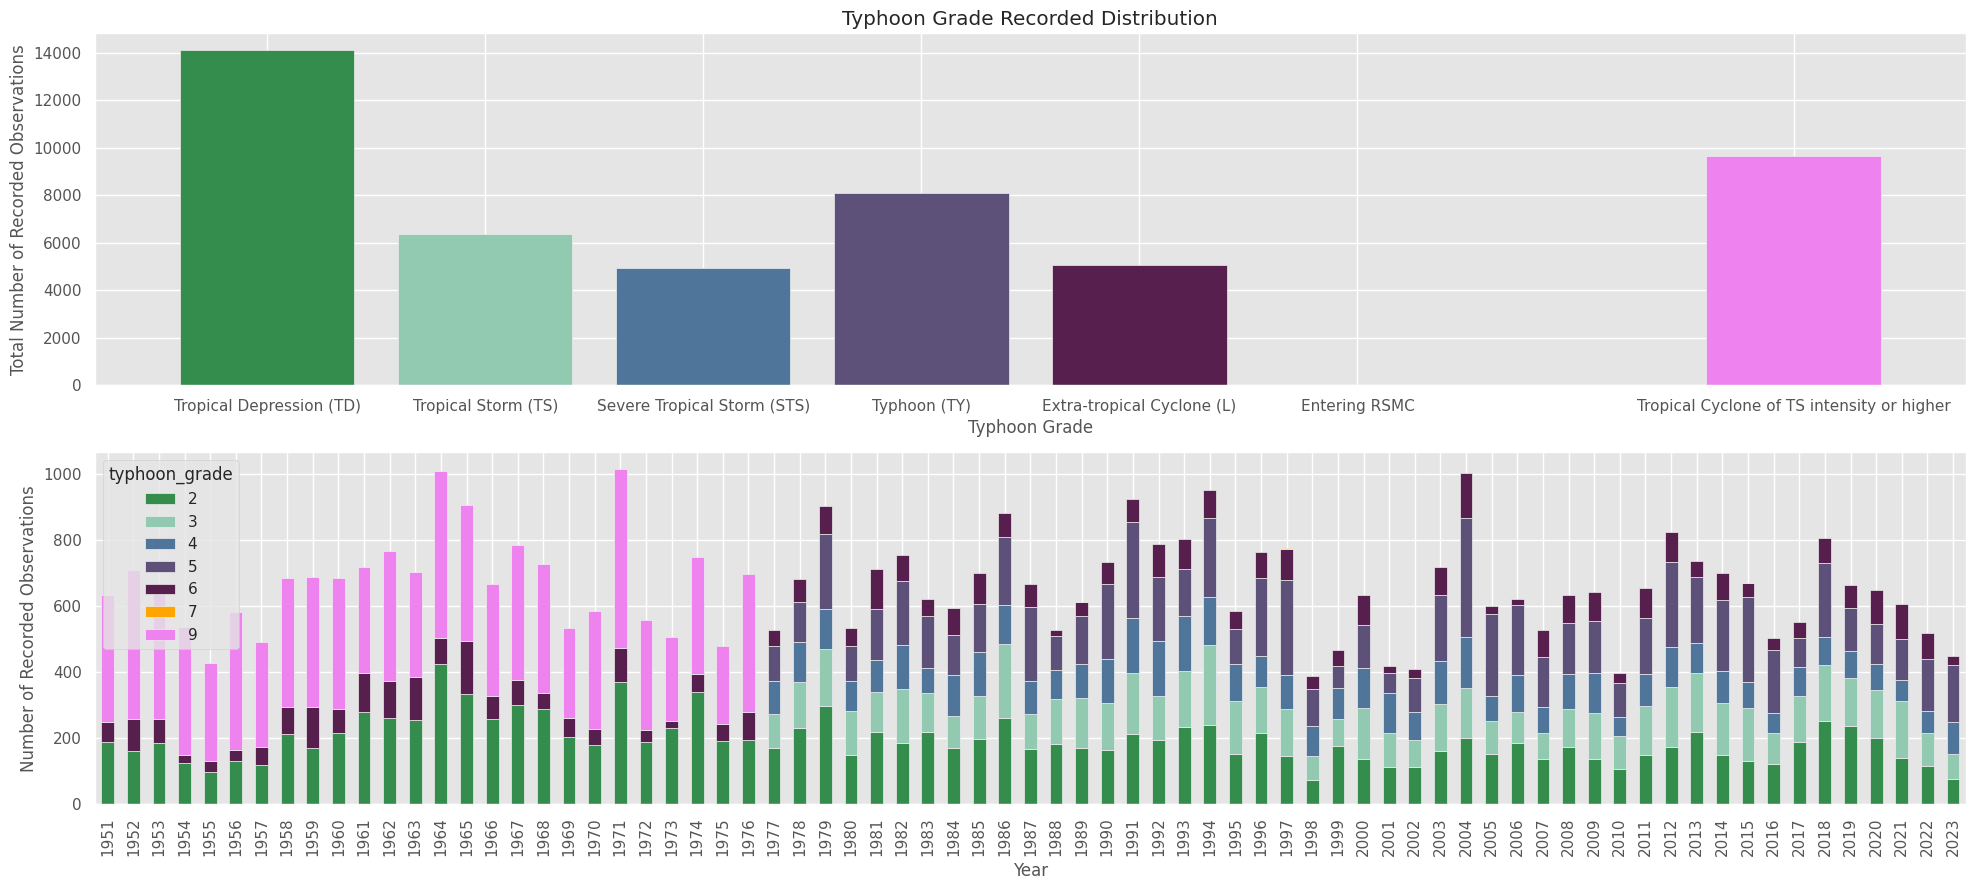

In [82]:
# Initial Visualization for the raw dataset
initial_visualization = True

typhoon_category = {'Tropical Depression (TD)':2,'Tropical Storm (TS)':3,'Severe Tropical Storm (STS)':4,'Typhoon (TY)':5,'Extra-tropical Cyclone (L)':6,'Entering RSMC':7,'Tropical Cyclone of TS intensity or higher':9}

typ_grade_colors = ['#348C4D', '#92C9B1', '#4F759B', '#5D5179','#571F4E','orange','violet']

if initial_visualization:

  # PAR Typhoon Grade Distribution
  typ_grade = typPAR['typhoon_grade'].value_counts().sort_index()
  typ_grade = pd.DataFrame(typ_grade).reset_index()

  plt.style.use('ggplot')

  fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 9))

  axes[0].bar(typ_grade['typhoon_grade'],typ_grade['count'],color=typ_grade_colors)
  axes[0].set_xlabel("Typhoon Grade")
  axes[0].set_ylabel("Total Number of Recorded Observations")
  axes[0].set_title("Typhoon Grade Recorded Distribution")
  axes[0].set_xticks(typ_grade['typhoon_grade'])
  axes[0].set_xticklabels(list(typhoon_category.keys()))

  # PAR Typhoon Grade Stack over time
  typ_grade_over_time = typPAR.groupby(typPAR.index.year)['typhoon_grade'].value_counts()
  typ_grade_over_time = pd.DataFrame(typ_grade_over_time).reset_index()

  tab = typ_grade_over_time.pivot_table(index='datetime', columns='typhoon_grade', values='count', aggfunc='sum', fill_value=0)

  axes[1]=tab.plot(kind='bar', stacked=True, color=typ_grade_colors, ax=axes[1])
  axes[1].set(xlabel='Year', ylabel='Number of Recorded Observations')

  fig.tight_layout()

  fig.show()
  fig.savefig('TY_Grade_Dist.png', dpi=100)

In [83]:
### Secondary Data Transformation - Fitting to the ts_data
# Add two features - one for typhoon_obs and one for typhoon_count
# typhoon_obs - number of typhoons being observed every month
# typhoon_count - number of typhoon occurence
# observation were omitted.

# Extract Year and Month from datetime
typPAR_data = typPAR.copy()
typPAR_data['year'] = typPAR_data.index.year
typPAR_data['month'] = typPAR_data.index.month

# Count the number of instance per typhoon per month and year
typhoon_obs = typPAR_data.groupby(['year','month'])['international_id'].agg([
    ('typhoon_obs', 'nunique'),  # Count unique typhoons
    ('typhoon_ids', lambda x: list(x.unique()))  # List of typhoon IDs
]).reset_index()

typhoon_obs['datatime'] = typhoon_obs['year'].astype(str) + '-' + typhoon_obs['month'].astype(str)
typhoon_obs.set_index('datatime', inplace=True)
typhoon_obs.index = pd.to_datetime(typhoon_obs.index, format = '%Y-%m')
print(tabulate(typhoon_obs.head(5), headers='keys', tablefmt='psql'))

print(f"\nTransformed data shape: {typhoon_obs.shape}")
print(f"Date range: {typhoon_obs.index.min()} to {typhoon_obs.index.max()}")

# Retrieve the first observation record per typhoon
typ_count_temp = typhoon_obs.copy()

# Reshape typhoon_id entries
max_elements = typ_count_temp['typhoon_ids'].apply(len).max()
print(max_elements)
typ_count_temp['typhoon_ids'] = typ_count_temp['typhoon_ids'].apply(lambda x: x + [None] * (max_elements - len(x)))

# Create a list of lagged row comparisons
entry = {'entry_0':typ_count_temp['typhoon_ids'][0][0]} #start of the series
for i in range(1,typ_count_temp.shape[0]):
  if typ_count_temp['typhoon_ids'][i] == typ_count_temp['typhoon_ids'][i-1]:
    entry[f'entry_{i}'] = 0
  elif typ_count_temp['typhoon_ids'][i] != typ_count_temp['typhoon_ids'][i-1]:
    entry[f'entry_{i}'] = next((x for x in reversed(typ_count_temp['typhoon_ids'][i]) if x is not None), None)

# Check Entry Values:
entry_value_list = list(entry.values())
s = pd.Series(entry_value_list)

# creates a series that removes the consecutive duplicates after the
# new number appears.
out = s.mask((s != 0) & s.duplicated(),0).tolist()
out_mask = [True if x != 0 else False for x in out]
print(out_mask)

# Produces an actual count of the typhoon
list_comp = list(typ_count_temp['typhoon_ids'])
typ_C = []
prev = set()
for row in list_comp:
    cur = {x for x in row if x is not None}      # ignore None, use distinct values
    typ_C.append(len(cur - prev))             # count values newly appearing
    prev = cur

print(typ_C)

typ_count_temp['id_entry'] = list(entry.values())
typ_count_temp['state_changed'] = list(out_mask) # This only account for 1 typhoon, if there are two or more, it will not display in the table. This acts as a marker for any new typhoon entity that was recorded, not the actual count.

typ_count_temp['typhoon_counts'] = typ_C

total_typ_C = sum(1 for x in typ_C if x != 0)
print(f'Total number of typhoons in PAR: {total_typ_C}') # Total number of typhoons in PAR from 1951-2021
#print(tabulate(typ_count_temp.head(500), headers='keys', tablefmt='psql'))

typ_count_temp = typ_count_temp[['year','month','typhoon_obs','typhoon_counts']]

print(tabulate(typ_count_temp.head(5), headers='keys', tablefmt='psql'))



+---------------------+--------+---------+---------------+------------------------------------------------------------------+
| datatime            |   year |   month |   typhoon_obs | typhoon_ids                                                      |
|---------------------+--------+---------+---------------+------------------------------------------------------------------|
| 1951-04-01 00:00:00 |   1951 |       4 |             2 | [np.int64(5103), np.int64(5104)]                                 |
| 1951-05-01 00:00:00 |   1951 |       5 |             1 | [np.int64(5104)]                                                 |
| 1951-06-01 00:00:00 |   1951 |       6 |             1 | [np.int64(5106)]                                                 |
| 1951-07-01 00:00:00 |   1951 |       7 |             3 | [np.int64(5106), np.int64(5107), np.int64(5109)]                 |
| 1951-08-01 00:00:00 |   1951 |       8 |             4 | [np.int64(5109), np.int64(5110), np.int64(5111), np.int64(5

In [84]:
# Create the Time Series Dataset

ts_data_s = typ_count_temp.copy()
ts_data_s = ts_data_s[['typhoon_obs','typhoon_counts']]
print(f"\nTarget variable (typhoon_count) statistics:")
print(ts_data_s['typhoon_counts'].describe())

# Check for gaps in time series
time_diff = ts_data_s.index.to_series().diff()
most_common_freq = time_diff.value_counts().head(1)
print(f"\nMost common time frequency: {most_common_freq.index[0]}")

# Handle any missing timestamps by reindexing
full_range = pd.date_range(start=ts_data_s.index.min(),
                          end=ts_data_s.index.max(),
                          freq='MS') # 1 month resolution

ts_data_s = ts_data_s.reindex(full_range, fill_value=0)
print(f"After reindexing: {len(ts_data_s)} observations")

# Separate typhoon observation and typhoon count for separate TSF modeling
ts_obs = ts_data_s[['typhoon_obs']].astype(float)
ts_count = ts_data_s[['typhoon_counts']].astype(float)

# Fill zero values with values (linear, polynomial, or spline) between non-zero values
#ts_obs = ts_obs.replace(0, np.nan).interpolate(method = 'linear',limit_direction='both')
#ts_count = ts_count.replace(0, np.nan).interpolate(method = 'linear',limit_direction='both')

# Drop 2021-... values
ts_obs = ts_obs.loc[ts_obs.index.year <= 2021]
ts_count = ts_count.loc[ts_count.index.year <= 2021]

print(tabulate(ts_obs.head(20), headers='keys', tablefmt='psql'))
print(tabulate(ts_count.tail(20), headers='keys', tablefmt='psql'))




Target variable (typhoon_count) statistics:
count    607.000000
mean       2.123558
std        1.375009
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: typhoon_counts, dtype: float64

Most common time frequency: 31 days 00:00:00
After reindexing: 873 observations
+---------------------+---------------+
|                     |   typhoon_obs |
|---------------------+---------------|
| 1951-04-01 00:00:00 |             2 |
| 1951-05-01 00:00:00 |             1 |
| 1951-06-01 00:00:00 |             1 |
| 1951-07-01 00:00:00 |             3 |
| 1951-08-01 00:00:00 |             4 |
| 1951-09-01 00:00:00 |             3 |
| 1951-10-01 00:00:00 |             3 |
| 1951-11-01 00:00:00 |             2 |
| 1951-12-01 00:00:00 |             2 |
| 1952-01-01 00:00:00 |             0 |
| 1952-02-01 00:00:00 |             0 |
| 1952-03-01 00:00:00 |             0 |
| 1952-04-01 00:00:00 |             0 |
| 1952-05-01 00:00:00 |             0

+---------------------+------------------+-----------------+
|                     |   typhoon_counts |   typhoon_count |
|---------------------+------------------+-----------------|
| 1951-04-01 00:00:00 |                2 |               2 |
| 1951-05-01 00:00:00 |                0 |               0 |
| 1951-06-01 00:00:00 |                1 |               1 |
| 1951-07-01 00:00:00 |                2 |               2 |
| 1951-08-01 00:00:00 |                3 |               3 |
+---------------------+------------------+-----------------+

2. EXPLORATORY DATA ANALYSIS
--------------------------------------------------

Typhoon Activity Statistics:
Total time periods: 849
Periods with typhoons: 551
Periods without typhoons: 298
Max typhoons at once: 6.0
Average typhoons when active: 2.29

Average Typhoon Count by Month:
  Jan: 0.30
  Feb: 0.17
  Mar: 0.26
  Apr: 0.41
  May: 0.85
  Jun: 1.55
  Jul: 2.80
  Aug: 3.38
  Sep: 2.97
  Oct: 2.46
  Nov: 1.76
  Dec: 0.90

Peak typhoon months:

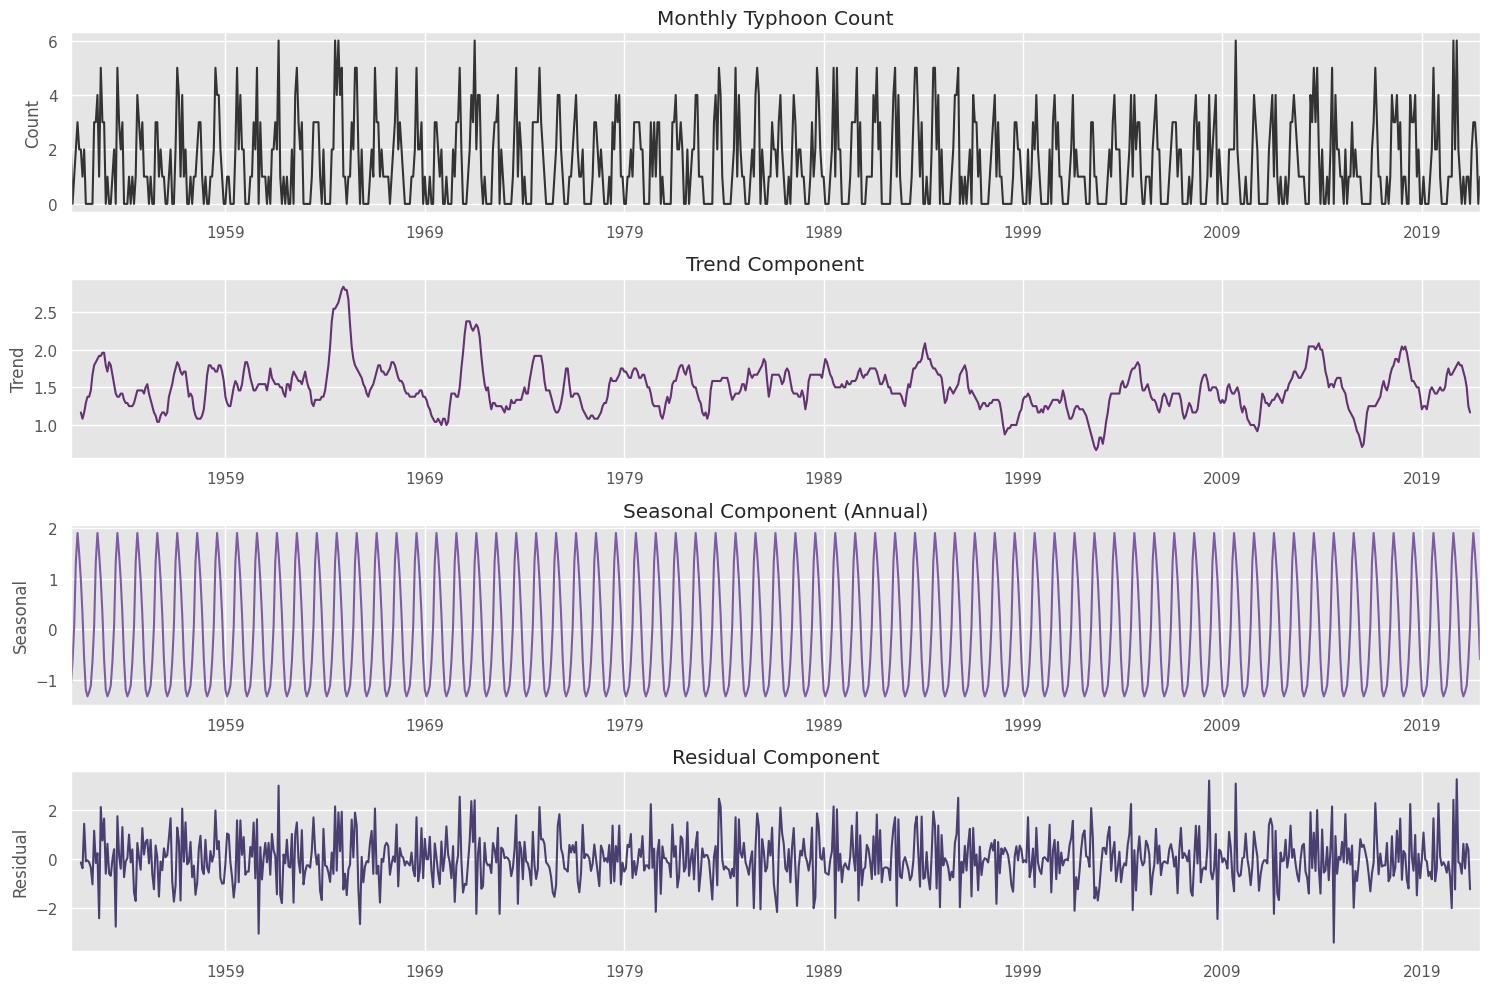

In [85]:
################################################################################
# Exploratory Data Analysis for Time Series Forecasting
################################################################################

ts_data = ts_count.copy()
ts_data['typhoon_count'] = ts_data['typhoon_counts']
print(tabulate(ts_data.head(5), headers='keys', tablefmt='psql'))

print("\n2. EXPLORATORY DATA ANALYSIS")
print("-" * 50)

# Basic statistics
print("\nTyphoon Activity Statistics:")
print(f"Total time periods: {len(ts_data)}")
print(f"Periods with typhoons: {(ts_data['typhoon_count'] > 0).sum()}")
print(f"Periods without typhoons: {(ts_data['typhoon_count'] == 0).sum()}")
print(f"Max typhoons at once: {ts_data['typhoon_count'].max()}")
print(f"Average typhoons when active: {ts_data[ts_data['typhoon_count'] > 0]['typhoon_count'].mean():.2f}")

# Analyze seasonality
ts_data['month'] = ts_data.index.month
ts_data['year'] = ts_data.index.year

# Monthly aggregation for seasonal pattern
monthly_avg = ts_data.groupby('month')['typhoon_count'].mean()
print("\nAverage Typhoon Count by Month:")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, (month, avg) in enumerate(monthly_avg.items()):
    print(f"  {months[i]}: {avg:.2f}")

# Peak typhoon season identification
peak_months = monthly_avg.nlargest(3).index.tolist()
print(f"\nPeak typhoon months: {[months[m-1] for m in peak_months]}")

# Yearly trend
yearly_stats = ts_data.groupby('year')['typhoon_count'].agg(['sum', 'mean', 'max'])
print(f"\nYearly trend (first and last 5 years):")
print(yearly_stats.head())
print("...")
print(yearly_stats.tail())

# Test for stationarity
# Remove temporary columns for further processing
ts_data_clean = ts_data[['typhoon_count']].copy()

adf_result = adfuller(ts_data_clean['typhoon_count'].dropna())
print(f"\nStationarity Test (ADF):")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Result: Series is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'}")

# Autocorrelation and Partial Autocorrelation
y = ts_data_clean['typhoon_count']
nlags = 12  # choose how far you want to look (one year)
acf_ci   = acf(y, nlags=nlags, alpha=0.05, fft=True, adjusted=False)[1:]
pacf_ci = pacf(y, nlags=nlags, alpha=0.05, method='ywmle')[1:]
acf_fig = plot_acf(y, lags=nlags, zero=False, auto_ylims=True)

plt.close(acf_fig)
pacf_fig = plot_pacf(y, lags=nlags, method='ywmle', zero=False, auto_ylims=True)
plt.close(pacf_fig)

acf_fig.savefig("acf.png", dpi=300, bbox_inches="tight")
pacf_fig.savefig("pacf.png", dpi=300, bbox_inches="tight")

print("\nACF and PACF plots saved as 'acf.png' and 'pacf.png'")

# Decomposition for daily aggregated data
monthly_data = ts_data_clean.resample('MS').sum()

c2_palette = ['#333333','#643173','#7D5BA6','#4B3F72']
if len(monthly_data) > 12*2:  # Need at least 2 years for meaningful decomposition
    decomposition = seasonal_decompose(
        monthly_data['typhoon_count'].dropna(),
        model='additive',
        period = 12  # yearly seasonality
    )

    fig, axes = plt.subplots(4, 1, figsize=(15, 10) )
    monthly_data['typhoon_count'].plot(ax=axes[0], title='Monthly Typhoon Count',color =c2_palette[0] )
    axes[0].set_ylabel('Count')

    decomposition.trend.plot(ax=axes[1], title='Trend Component',color =c2_palette[1] )
    axes[1].set_ylabel('Trend')

    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component (Annual)',color =c2_palette[2] )
    axes[2].set_ylabel('Seasonal')

    decomposition.resid.plot(ax=axes[3], title='Residual Component',color =c2_palette[3] )
    axes[3].set_ylabel('Residual')

    plt.tight_layout()
    plt.savefig('typhoon_decomposition.png', dpi=100)
    print("\n✓ Decomposition plot saved as 'typhoon_decomposition.png'")

# Add statistical test
# Visual analysis
# Advanced EDA techniques
# Show tsfeatures

In [86]:
################################################################################
# Feature Engineering
################################################################################
print("\n3. FEATURE ENGINEERING")
print("-" * 50)

feature_df_df = ts_data_clean.copy()

def create_features(feature_df):
  ''' Creates features for your dataframe'''
  # Lag features - important for capturing typhoon persistence - monthly, quarterly, half-year, yearly, bi-annual
  lag_periods = [1,2,4,6]  # Up to 4 years
  for lag in lag_periods:
      feature_df[f'lag_{lag}'] = feature_df['typhoon_count'].shift(lag)

  # Rolling statistics - capture recent activity patterns
  windows = [6, 12]  # 6 months, 12 months, 24 months, 36 months, 48 months
  for window in windows:
      feature_df[f'rolling_mean_{window}'] = feature_df['typhoon_count'].rolling(window).mean()
      feature_df[f'rolling_std_{window}'] = feature_df['typhoon_count'].rolling(window).std()
      feature_df[f'rolling_max_{window}'] = feature_df['typhoon_count'].rolling(window).max()
      feature_df[f'rolling_sum_{window}'] = feature_df['typhoon_count'].rolling(window).sum()

  # Temporal features
  feature_df['month'] = feature_df.index.month
  feature_df['quarter'] = feature_df.index.quarter
  feature_df['year'] = feature_df.index.year

  # Cyclical encoding for temporal patterns

  feature_df['month_sin'] = np.sin(2 * np.pi * feature_df['year'] / 12)
  feature_df['month_cos'] = np.cos(2 * np.pi * feature_df['year'] / 12)
  feature_df['quarter_sin'] = np.sin(2 * np.pi * feature_df['year'] /4)
  feature_df['quarter_cos'] = np.cos(2 * np.pi * feature_df['year'] /4)
  feature_df['half_year_sin'] = np.sin(2 * np.pi * feature_df['year']/6)
  feature_df['half_year_cos'] = np.cos(2 * np.pi * feature_df['year']/6)
  feature_df['year_sin'] = np.sin(2 * np.pi * feature_df['year'])
  feature_df['year_cos'] = np.cos(2 * np.pi * feature_df['year'])


  # Binary features (have two versions - one for typhoon first existence count and one for typhoon persistence)

  # Typhoon first existence
  feature_df['new_recorded_typ'] = (feature_df['typhoon_count'] > 0).astype(int)
  feature_df['new_typ_last_month'] = (feature_df['lag_1'] > 0).astype(int)
  feature_df['new_typ_last_quarter'] = (feature_df['lag_4'] > 0).astype(int)
  feature_df['new_typ_last_half_year'] = (feature_df['lag_6'] > 0).astype(int)
  feature_df['total_typ_last_6_months'] = (feature_df['rolling_sum_6'] > 0).astype(int)
  feature_df['total_typ_last_year'] = (feature_df['rolling_sum_12'] > 0).astype(int)

  # Interaction features
  feature_df['month_x_rolling_mean'] = feature_df['month'] * feature_df['rolling_mean_12']

  #print(tabulate(feature_df.head(5), headers='keys', tablefmt='psql'))

  # Remove NaN rows created by feature engineering
  feature_df = feature_df.dropna()

  print(f"Features created: {len(feature_df.columns) - 1}")
  print(f"Dataset shape after feature engineering: {feature_df.shape}")

  # List top features by correlation with target
  correlations = feature_df.corr()['typhoon_count'].sort_values(ascending=False)
  print("\nTop 10 correlated features:")
  for feat, corr in correlations.head(11).items():  # 11 because first is target itself
      if feat != 'typhoon_count':
          print(f"  {feat}: {corr:.3f}")

  return correlations, feature_df

feature_df = create_features(feature_df_df)[1]

print(tabulate(feature_df.head(5), headers='keys', tablefmt='psql'))



3. FEATURE ENGINEERING
--------------------------------------------------
Features created: 30
Dataset shape after feature engineering: (838, 31)

Top 10 correlated features:
  new_recorded_typ: 0.724
  month_x_rolling_mean: 0.503
  quarter: 0.479
  month: 0.461
  lag_1: 0.452
  new_typ_last_month: 0.415
  rolling_max_6: 0.352
  rolling_std_6: 0.333
  rolling_sum_6: 0.306
  rolling_mean_6: 0.306
+---------------------+-----------------+---------+---------+---------+---------+------------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+---------+-----------+--------+-------------+-------------+---------------+---------------+-----------------+-----------------+--------------+------------+--------------------+----------------------+------------------------+--------------------------+---------------------------+-----------------------+------------------------+
|                     |   typhoon_count 


4. SPLITTING DATA FOR TRAINING AND EVALUATION
--------------------------------------------------
Train: 670 samples (1952-03-01 00:00:00 to 2007-12-01 00:00:00)
Val:   83 samples (2008-01-01 00:00:00 to 2014-11-01 00:00:00)
Test:  85 samples (2014-12-01 00:00:00 to 2021-12-01 00:00:00)

Typhoon existence rates:
  Train: 64.9% of periods have typhoons
  Val:   61.4% of periods have typhoons
  Test:  67.1% of periods have typhoons
Saved Data_Splitting.png Successfully


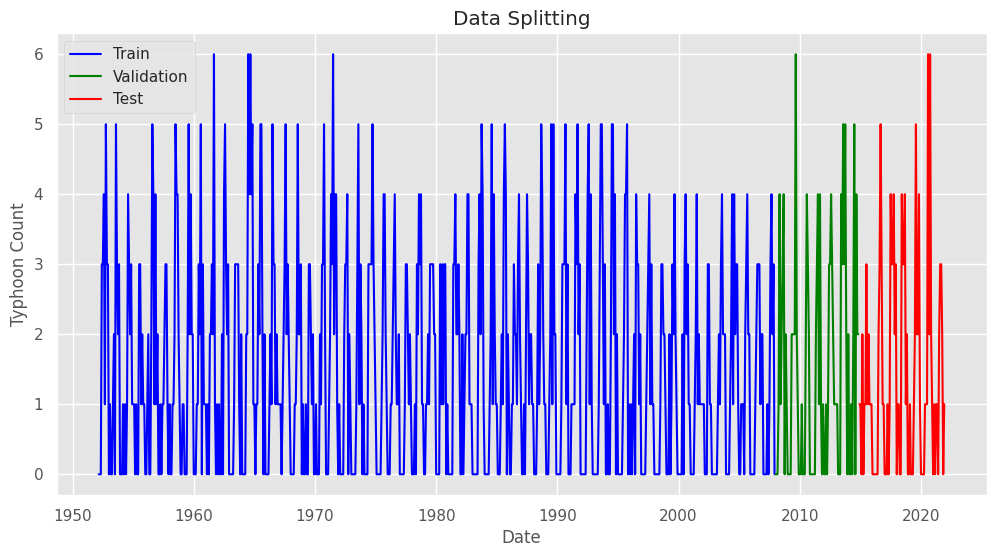

In [87]:
################################################################################
# Data Splitting and Preparation
################################################################################

print("\n4. SPLITTING DATA FOR TRAINING AND EVALUATION")
print("-" * 50)

# Use time-based splitting
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

n = len(feature_df)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = feature_df.iloc[:train_size]
val_data = feature_df.iloc[train_size:train_size + val_size]
test_data = feature_df.iloc[train_size + val_size:]

print(f"Train: {len(train_data)} samples ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Val:   {len(val_data)} samples ({val_data.index[0]} to {val_data.index[-1]})")
print(f"Test:  {len(test_data)} samples ({test_data.index[0]} to {test_data.index[-1]})")

# Calculate base rates for each set
print(f"\nTyphoon existence rates:")
print(f"  Train: {(train_data['typhoon_count'] > 0).mean()*100:.1f}% of periods have typhoons")
print(f"  Val:   {(val_data['typhoon_count'] > 0).mean()*100:.1f}% of periods have typhoons")
print(f"  Test:  {(test_data['typhoon_count'] > 0).mean()*100:.1f}% of periods have typhoons")

# Prepare features and target
feature_cols = [col for col in feature_df.columns if col != 'typhoon_count']
target_col = 'typhoon_count'

# Scale features
scaler_features = StandardScaler()
scaler_target = StandardScaler()  # Use StandardScaler for count data

X_train = scaler_features.fit_transform(train_data[feature_cols])
X_val = scaler_features.transform(val_data[feature_cols])
X_test = scaler_features.transform(test_data[feature_cols])

y_train = train_data[target_col].values
y_val = val_data[target_col].values
y_test = test_data[target_col].values

# Plot the Data Splitting
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data[target_col], label='Train', color='blue')
plt.plot(val_data.index, val_data[target_col], label='Validation', color='green')
plt.plot(test_data.index, test_data[target_col], label='Test', color='red')
plt.xlabel('Date')
plt.ylabel('Typhoon Count')
plt.title('Data Splitting')
plt.legend()
plt.savefig('Data_Splitting.png')
print('Saved Data_Splitting.png Successfully')
plt.show()

In [88]:
################################################################################
# Model Training
################################################################################

print("\n5. TRAINING FORECASTING MODELS")
print("-" * 50)

models = {}
predictions = {}
model_details = {}

# -----------------------------
# Model 1: SARIMAX
# -----------------------------
print("\n>>> Training SARIMAX...")
try:
    # Use subset for computational efficiency
    sarimax_train = train_data[target_col].iloc[-5000:] if len(train_data) > 5000 else train_data[target_col]
    print(sarimax_train.shape)

    # Fit SARIMAX with seasonal component
    sarimax_model = SARIMAX(
        sarimax_train,
        order=(1, 1, 1),  # ARIMA order (p,d,q)
        seasonal_order=(2, 1, 1, 12),  # Annual seasonality (12 * 1 month)
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarimax_fitted = sarimax_model.fit(disp=False, maxiter=100)
    models['SARIMAX'] = sarimax_fitted

    # Generate predictions
    sarimax_pred = sarimax_fitted.forecast(steps=len(val_data))
    sarimax_pred = np.maximum(sarimax_pred, 0)  # Ensure non-negative
    predictions['SARIMAX'] = sarimax_pred

    model_details['SARIMAX'] = {
        'AIC': sarimax_fitted.aic,
        'BIC': sarimax_fitted.bic
    }

    print(f"   ✓ SARIMAX trained | AIC: {sarimax_fitted.aic:.2f}, BIC: {sarimax_fitted.bic:.2f}")

except Exception as e:
    print(f"   ✗ SARIMAX failed: {str(e)[:100]}")
    predictions['SARIMAX'] = np.zeros(len(val_data))

print(models)


5. TRAINING FORECASTING MODELS
--------------------------------------------------

>>> Training SARIMAX...
(670,)
   ✓ SARIMAX trained | AIC: 1864.24, BIC: 1890.93
{'SARIMAX': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7a4ff2d4bbc0>}


In [89]:
# -----------------------------
# Model 2: Prophet
# -----------------------------
print("\n>>> Training Prophet...")
try:
    # Prepare data for Prophet
    train_data_prophet = train_data.copy()
    train_data_prophet['ds'] = train_data_prophet.index
    train_data_prophet['y'] = train_data_prophet[target_col]
    prophet_train = train_data_prophet.reset_index()[['ds', target_col]]
    prophet_train.columns = ['ds', 'y']

    print(prophet_train.head(5))
    # Sample if too large
    if len(prophet_train) > 10000:
        prophet_train = prophet_train.iloc[-10000:]

    # Configure Prophet for count data
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        interval_width=0.95,
        changepoint_prior_scale=0.5
    )

    # Add monthly seasonality
    prophet_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

    prophet_model.fit(prophet_train)
    models['Prophet'] = prophet_model

    # Generate forecasts
    future = prophet_model.make_future_dataframe(periods=len(val_data), freq='MS')
    forecast = prophet_model.predict(future)
    prophet_pred = forecast['yhat'].iloc[-len(val_data):].values
    prophet_pred = np.maximum(prophet_pred, 0)  # Ensure non-negative
    predictions['Prophet'] = prophet_pred

    print(f"   ✓ Prophet trained successfully")

except Exception as e:
    print(f"   ✗ Prophet failed: {str(e)[:100]}")
    predictions['Prophet'] = np.zeros(len(val_data))


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/nz9msrxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/21kln704.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91069', 'data', 'file=/tmp/tmp_6222zs3/nz9msrxv.json', 'init=/tmp/tmp_6222zs3/21kln704.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modelqn_zgnr8/prophet_model-20250908044228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



>>> Training Prophet...
          ds    y
0 1952-03-01  0.0
1 1952-04-01  0.0
2 1952-05-01  0.0
3 1952-06-01  3.0
4 1952-07-01  3.0


04:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


   ✓ Prophet trained successfully


In [90]:
# -----------------------------
# Model 3: XGBoost
# -----------------------------
print("\n>>> Training XGBoost...")
try:
    # XGBoost for count data - use Poisson objective
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        early_stopping_rounds=20,
        max_depth=6,
        learning_rate=0.05,
        objective='count:poisson',  # Better for count data
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    models['XGBoost'] = xgb_model
    xgb_pred = xgb_model.predict(X_val)
    predictions['XGBoost'] = xgb_pred

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    model_details['XGBoost'] = {'top_features': importance}

    print(f"   ✓ XGBoost trained | Best iteration: {xgb_model.best_iteration}")
    print(f"   Top 5 features:")
    for idx, row in importance.head(5).iterrows():
        print(f"     - {row['feature']}: {row['importance']:.3f}")

except Exception as e:
    print(f"   ✗ XGBoost failed: {str(e)[:100]}")
    predictions['XGBoost'] = np.zeros(len(val_data))



>>> Training XGBoost...
   ✓ XGBoost trained | Best iteration: 199
   Top 5 features:
     - new_recorded_typ: 0.736
     - month: 0.052
     - quarter: 0.030
     - rolling_max_6: 0.028
     - rolling_std_6: 0.020


In [91]:
# -----------------------------
# Model 4: Random Forest (for count data)
# -----------------------------
print("\n>>> Training Random Forest...")
try:
    from sklearn.ensemble import RandomForestRegressor

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)
    models['RandomForest'] = rf_model
    rf_pred = rf_model.predict(X_val)
    rf_pred = np.maximum(rf_pred, 0)  # Ensure non-negative
    predictions['RandomForest'] = rf_pred

    print(f"   ✓ Random Forest trained successfully")

except Exception as e:
    print(f"   ✗ Random Forest failed: {str(e)[:100]}")
    predictions['RandomForest'] = np.zeros(len(val_data))


>>> Training Random Forest...
   ✓ Random Forest trained successfully


In [92]:
# -----------------------------
# Model 5: Exponential Smoothing
# -----------------------------
print("\n>>> Training Exponential Smoothing...")
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing

    # Use subset for efficiency
    es_train = train_data[target_col].iloc[-5000:] if len(train_data) > 5000 else train_data[target_col]

    es_model = ExponentialSmoothing(
        es_train,
        seasonal_periods=12,  # 1 year
        trend='add',
        seasonal='add',
        use_boxcox=False
    )

    es_fitted = es_model.fit()
    models['ExpSmoothing'] = es_fitted
    es_pred = es_fitted.forecast(len(val_data))
    es_pred = np.maximum(es_pred, 0)  # Ensure non-negative
    predictions['ExpSmoothing'] = es_pred

    print(f"   ✓ Exponential Smoothing trained successfully")

except Exception as e:
    print(f"   ✗ Exponential Smoothing failed: {str(e)[:100]}")
    predictions['ExpSmoothing'] = np.zeros(len(val_data))



>>> Training Exponential Smoothing...
   ✓ Exponential Smoothing trained successfully


In [93]:
# -----------------------------
# Baseline Models
# -----------------------------
print("\n>>> Creating baseline models...")

# Moving Average
window = 2  # 2 months
ma_predictions = []
for i in range(len(val_data)):
    if i < window:
        lookback = np.concatenate([
            train_data[target_col].iloc[-(window-i):].values,
            val_data[target_col].iloc[:i].values
        ])
    else:
        lookback = val_data[target_col].iloc[i-window:i].values

    ma_predictions.append(lookback.mean() if len(lookback) > 0 else 0)

predictions['MovingAvg_2months'] = np.array(ma_predictions)

# Seasonal Naive (same time last week)
seasonal_period = 12 # 1 year
seasonal_naive = []
for i in range(len(val_data)):
    if i >= seasonal_period:
        seasonal_naive.append(val_data[target_col].iloc[i-seasonal_period])
    else:
        # Use training data for initial predictions
        train_idx = len(train_data) - (seasonal_period - i)
        if train_idx >= 0:
            seasonal_naive.append(train_data[target_col].iloc[train_idx])
        else:
            seasonal_naive.append(0)

predictions['SeasonalNaive'] = np.array(seasonal_naive)

print(f"   ✓ Baseline models created")


>>> Creating baseline models...
   ✓ Baseline models created


In [94]:
################################################################################
# Model Evaluation
################################################################################

print("\n6. MODEL EVALUATION ON VALIDATION SET")
print("-" * 50)

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics for count data"""
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Standard regression metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE with adjustment for zero values
    mask = y_true > 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    # R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    # Poisson deviance (good for count data)
    mask_pos = (y_true > 0) & (y_pred > 0)
    if mask_pos.sum() > 0:
        poisson_dev = 2 * np.sum(y_true[mask_pos] * np.log(y_true[mask_pos] / y_pred[mask_pos])
                                 - (y_true[mask_pos] - y_pred[mask_pos]))
    else:
        poisson_dev = np.nan

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Poisson_Dev': poisson_dev
    }

evaluation_results = []

for model_name, preds in predictions.items():
    metrics = calculate_metrics(y_val, preds)
    metrics['Model'] = model_name
    evaluation_results.append(metrics)

eval_df = pd.DataFrame(evaluation_results)
eval_df = eval_df[['Model', 'RMSE', 'MAE', 'MAPE', 'R²', 'Poisson_Dev']]
eval_df = eval_df.sort_values('RMSE')

print("\nValidation Set Performance:")
print(eval_df.to_string())


6. MODEL EVALUATION ON VALIDATION SET
--------------------------------------------------

Validation Set Performance:
               Model      RMSE       MAE       MAPE        R²  Poisson_Dev
2            XGBoost  0.569231  0.337322  27.218490  0.868648    10.880385
3       RandomForest  0.625386  0.354161  32.054409  0.841454    12.966095
0            SARIMAX  1.145826  0.811794  47.395773  0.467772    53.986895
4       ExpSmoothing  1.147871  0.817674  47.069887  0.465870    49.874512
1            Prophet  1.169456  0.815669  50.476399  0.445593    53.558412
6      SeasonalNaive  1.414214  0.987952  63.627451  0.189243    36.409957
5  MovingAvg_2months  1.617860  1.198795  66.683007 -0.061066    61.598686


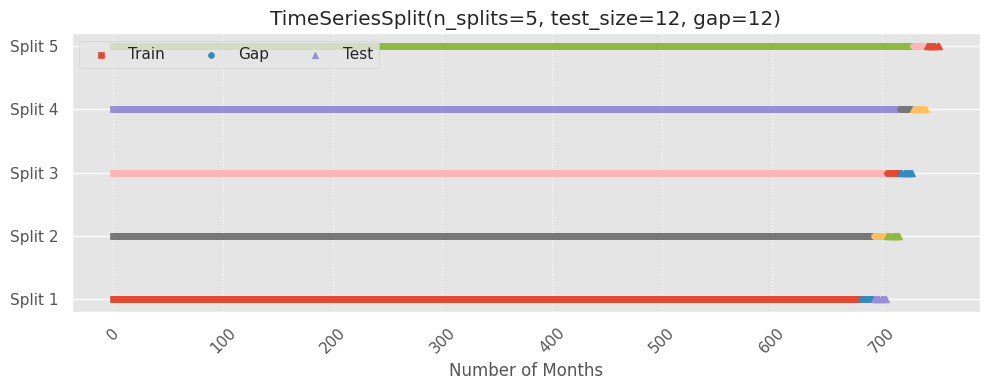

Saved TimeSeriesSplit.png Successfully


In [95]:
# Visualizing Walk-Forward Cross Validation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

n_obs = len(feature_df[target_col])
X_temp_data = pd.concat([train_data, val_data]).iloc[-20000:]

tsf_splits = 5
tsf_test_size = 12
tsf_gap = 12

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=tsf_splits, test_size=tsf_test_size, gap=tsf_gap)

fig, ax = plt.subplots(figsize=(10, 4))
for i, (tr, te) in enumerate(tscv.split(X_temp_data)):
    gap = np.arange(tr[-1] + 1, te[0])     # indices between train end and test start
    ax.scatter(tr,  np.full_like(tr,  i), marker='s', s=18, label='Train' if i==0 else None)
    if len(gap):
        ax.scatter(gap, np.full_like(gap, i), marker='o', s=18, label='Gap' if i==0 else None)
    ax.scatter(te,  np.full_like(te,  i), marker='^', s=22, label='Test' if i==0 else None)

ax.set_yticks(range(5)); ax.set_yticklabels([f"Split {k+1}" for k in range(5)])
ax.set_xlabel('Number of Months'); ax.set_title(f"TimeSeriesSplit(n_splits={tsf_splits}, test_size={tsf_test_size}, gap={tsf_gap})")
ax.legend(loc="upper left", ncols=3); ax.grid(True, axis='x', linestyle=':', linewidth=0.8)
ax.tick_params(axis='x',rotation=45)
plt.tight_layout(); plt.show()
fig.savefig('TimeSeriesSplit.png')
print('Saved TimeSeriesSplit.png Successfully')


In [96]:
################################################################################
# Walk-Forward Validation
################################################################################
print("\n7. WALK-FORWARD VALIDATION")
print("-" * 50)

# Perform time series cross-validation for top models
top_models = eval_df.head(6)['Model'].values
cv_results = []
print(top_models)
print(f"Performing 5-fold walk-forward validation for top 3 models...")

for model_name in top_models:
    print(f"   Evaluating {model_name}...")
    if model_name not in ['MovingAvg_2months', 'SeasonalNaive']:
        tscv = TimeSeriesSplit(n_splits=5, test_size=12, gap = 12)
        # Time Series Split plot

        cv_scores = []

        # Use subset of data for efficiency
        cv_data = pd.concat([train_data, val_data]).iloc[-20000:]

        for fold, (train_idx, test_idx) in enumerate(tscv.split(cv_data)):
            print(f"      Fold {fold}...")
            try:
                cv_train = cv_data.iloc[train_idx]
                cv_test = cv_data.iloc[test_idx]

                if model_name == 'XGBoost':
                    X_cv_train = scaler_features.transform(cv_train[feature_cols])
                    X_cv_test = scaler_features.transform(cv_test[feature_cols])
                    y_cv_test = cv_test[target_col].values

                    # Quick training without early stopping
                    temp_model = xgb.XGBRegressor(
                        n_estimators=50,
                        max_depth=6,
                        objective='count:poisson',
                        random_state=42
                    )
                    temp_model.fit(X_cv_train, cv_train[target_col].values, verbose=False)
                    cv_pred = temp_model.predict(X_cv_test)
                    print('XGB success')

                elif model_name == 'RandomForest':
                    X_cv_train = scaler_features.transform(cv_train[feature_cols])
                    X_cv_test = scaler_features.transform(cv_test[feature_cols])
                    y_cv_test = cv_test[target_col].values

                    print('temp training')
                    # Quick training without early stopping
                    temp_model = RandomForestRegressor(
                                      n_estimators=100,
                                      max_depth=10,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      random_state=42,
                                      n_jobs=-1
                                  )
                    print('temp fit')
                    temp_model.fit(X_cv_train, cv_train[target_col].values)
                    print('temp predict')
                    cv_pred = temp_model.predict(X_cv_test)
                    print(cv_pred)
                    print('RF success')

                elif model_name == 'Prophet':
                    # Walk-forward validation for Prophet (train up to cutoff, predict test window)

                    # Prepare training data for this fold
                    prophet_train = cv_train[[target_col]].reset_index()
                    prophet_train.columns = ['ds', 'y']

                    # Fit a simple Prophet model (tweak as you like)
                    temp_model = Prophet(
                        yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        interval_width=0.95
                    )
                    temp_model.fit(prophet_train)

                    # Determine frequency and account for the CV gap
                    freq = pd.infer_freq(cv_train.index) or pd.infer_freq(cv_data.index) or 'D'
                    gap_steps = getattr(tscv, 'gap', 0)

                    # Forecast exactly the test window after skipping the gap
                    future = temp_model.make_future_dataframe(periods=gap_steps + len(cv_test), freq=freq)
                    fcst = temp_model.predict(future)

                    # Extract predictions aligned with the fold's test dates
                    y_cv_test = cv_test[target_col].values
                    cv_pred = fcst.set_index('ds').loc[cv_test.index, 'yhat'].values
                    print('Prophet success')

                else:
                    continue  # Skip other models for efficiency

                fold_rmse = np.sqrt(mean_squared_error(y_cv_test, cv_pred))
                print(f"         Fold RMSE: {fold_rmse:.3f}")
                cv_scores.append(fold_rmse)

            except:
                continue

        if cv_scores:
            cv_results.append({
                'Model': model_name,
                'CV_Mean_RMSE': np.mean(cv_scores),
                'CV_Std_RMSE': np.std(cv_scores)
            })

if cv_results:
    cv_df = pd.DataFrame(cv_results)
    print("\nCross-Validation Results:")
    print(cv_df.to_string())




7. WALK-FORWARD VALIDATION
--------------------------------------------------
['XGBoost' 'RandomForest' 'SARIMAX' 'ExpSmoothing' 'Prophet'
 'SeasonalNaive']
Performing 5-fold walk-forward validation for top 3 models...
   Evaluating XGBoost...
      Fold 0...
XGB success
         Fold RMSE: 0.278
      Fold 1...
XGB success
         Fold RMSE: 0.529
      Fold 2...
XGB success
         Fold RMSE: 0.650
      Fold 3...
XGB success
         Fold RMSE: 0.926
      Fold 4...
XGB success
         Fold RMSE: 1.136
   Evaluating RandomForest...
      Fold 0...
temp training
temp fit
temp predict
[0.         0.         0.         1.37402381 0.         0.
 0.         1.82081966 3.80954282 2.83997459 2.94494544 0.        ]
RF success
         Fold RMSE: 0.306
      Fold 1...
temp training
temp fit
temp predict
[0.         0.         0.         0.         0.         1.79240686
 2.83933037 3.93727857 2.41635022 3.66119066 2.02075203 0.        ]
RF success
         Fold RMSE: 0.519
      Fold 2...

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/h1o92imp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/aau_88q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3911', 'data', 'file=/tmp/tmp_6222zs3/h1o92imp.json', 'init=/tmp/tmp_6222zs3/aau_88q2.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modelne_op76w/prophet_model-20250908044232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


temp predict
[0.         1.43448003 0.         0.         1.59769661 0.
 1.9266799  2.95976575 0.         4.23941654 3.79171182 1.98701577]
RF success
         Fold RMSE: 0.822
   Evaluating SARIMAX...
      Fold 0...
      Fold 1...
      Fold 2...
      Fold 3...
      Fold 4...
   Evaluating ExpSmoothing...
      Fold 0...
      Fold 1...
      Fold 2...
      Fold 3...
      Fold 4...
   Evaluating Prophet...
      Fold 0...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/n3uvd5kz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/04eb8zh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90745', 'data', 'file=/tmp/tmp_6222zs3/n3uvd5kz.json', 'init=/tmp/tmp_6222zs3/04eb8zh_.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modelrvs59ai7/prophet_model-20250908044233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet success
         Fold RMSE: 0.822
      Fold 1...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/cftleye5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/3hgc7e2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40326', 'data', 'file=/tmp/tmp_6222zs3/cftleye5.json', 'init=/tmp/tmp_6222zs3/3hgc7e2m.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modele5nmt_n9/prophet_model-20250908044233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet success
         Fold RMSE: 1.220
      Fold 2...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/ldah41bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/t15hf_2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77405', 'data', 'file=/tmp/tmp_6222zs3/ldah41bt.json', 'init=/tmp/tmp_6222zs3/t15hf_2n.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modelvcemw_4z/prophet_model-20250908044233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet success
         Fold RMSE: 0.622
      Fold 3...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/z2_paa55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6222zs3/pk8a1420.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59951', 'data', 'file=/tmp/tmp_6222zs3/z2_paa55.json', 'init=/tmp/tmp_6222zs3/pk8a1420.json', 'output', 'file=/tmp/tmp_6222zs3/prophet_modelwov4zm6c/prophet_model-20250908044233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet success
         Fold RMSE: 1.306
      Fold 4...
Prophet success
         Fold RMSE: 1.382
   Evaluating SeasonalNaive...

Cross-Validation Results:
          Model  CV_Mean_RMSE  CV_Std_RMSE
0       XGBoost      0.703829     0.300551
1  RandomForest      0.562857     0.168472
2       Prophet      1.070317     0.295922


In [97]:
################################################################################
# Final Test Set Validation
################################################################################

print("\n8. FINAL EVALUATION ON TEST SET")
print("-" * 50)

test_results = []
test_predictions = {}

for model_name in predictions.keys():
    try:
        if model_name == 'XGBoost' and 'XGBoost' in models:
            test_pred = models['XGBoost'].predict(X_test)
        elif model_name == 'RandomForest' and 'RandomForest' in models:
            test_pred = models['RandomForest'].predict(X_test)
        elif model_name == 'SARIMAX' and 'SARIMAX' in models:
            test_pred = models['SARIMAX'].forecast(steps=len(test_data))
            test_pred = np.maximum(test_pred, 0)
        elif model_name == 'Prophet' and 'Prophet' in models:
            future_test = models['Prophet'].make_future_dataframe(
                periods=len(val_data) + len(test_data), freq='MS'
            )
            forecast_test = models['Prophet'].predict(future_test)
            test_pred = forecast_test['yhat'].iloc[-len(test_data):].values
            test_pred = np.maximum(test_pred, 0)
        elif model_name == 'ExpSmoothing' and 'ExpSmoothing' in models:
            test_pred = models['ExpSmoothing'].forecast(len(test_data))
            test_pred = np.maximum(test_pred, 0)
        elif model_name == 'MovingAvg_2months':
            # Moving average for test set
            window = 2
            test_pred = []
            combined = pd.concat([val_data[target_col], test_data[target_col]])
            for i in range(len(test_data)):
                start_idx = len(val_data) + i - window
                if start_idx >= 0:
                    test_pred.append(combined.iloc[start_idx:len(val_data)+i].mean())
                else:
                    test_pred.append(val_data[target_col].mean())
            test_pred = np.array(test_pred)
        elif model_name == 'SeasonalNaive':
            # Seasonal naive for test set
            seasonal_period = 12
            test_pred = []
            for i in range(len(test_data)):
                source_idx = i % seasonal_period
                if source_idx < len(val_data):
                    test_pred.append(val_data[target_col].iloc[-seasonal_period+source_idx])
                else:
                    test_pred.append(val_data[target_col].mean())
            test_pred = np.array(test_pred)
        else:
            test_pred = np.zeros(len(test_data))

        test_predictions[model_name] = test_pred
        metrics = calculate_metrics(y_test, test_pred)
        metrics['Model'] = model_name
        test_results.append(metrics)

    except Exception as e:
        print(f"   Failed to evaluate {model_name} on test set: {str(e)[:50]}")
        test_predictions[model_name] = np.zeros(len(test_data))

test_df = pd.DataFrame(test_results)
test_df = test_df[['Model', 'RMSE', 'MAE', 'MAPE', 'R²']]
test_df = test_df.sort_values('RMSE')

print("\nTest Set Performance:")
print(test_df.to_string())

# Identify best model
best_model = test_df.iloc[0]['Model']
best_rmse = test_df.iloc[0]['RMSE']
best_mae = test_df.iloc[0]['MAE']

print(f"\n★ BEST MODEL: {best_model}")
print(f"  - Test RMSE: {best_rmse:.3f}")
print(f"  - Test MAE: {best_mae:.3f}")
print(f"  - Test MAPE: {test_df.iloc[0]['MAPE']:.1f}%")


8. FINAL EVALUATION ON TEST SET
--------------------------------------------------

Test Set Performance:
               Model      RMSE       MAE       MAPE        R²
2            XGBoost  0.507452  0.298072  24.962378  0.885339
3       RandomForest  0.557818  0.333303  32.871191  0.861448
1            Prophet  1.100424  0.716827  51.655976  0.460805
4       ExpSmoothing  1.292890  0.952847  63.948375  0.255698
0            SARIMAX  1.299984  0.950035  64.196955  0.247508
5  MovingAvg_2months  1.502938  1.117647  69.429825 -0.005793
6      SeasonalNaive  1.782266  1.317647  83.245614 -0.414397

★ BEST MODEL: XGBoost
  - Test RMSE: 0.507
  - Test MAE: 0.298
  - Test MAPE: 25.0%



9. CREATING VISUALIZATIONS
--------------------------------------------------
   quarter  typhoon_count
0        1           51.0
1        2          196.0
2        3          643.0
3        4          359.0
✓ Seasonal patterns saved as 'typhoon_patterns.png'
✓ Model performance comparison saved as 'model_performance.png'
✓ Best model analysis saved as 'best_model_analysis.png'


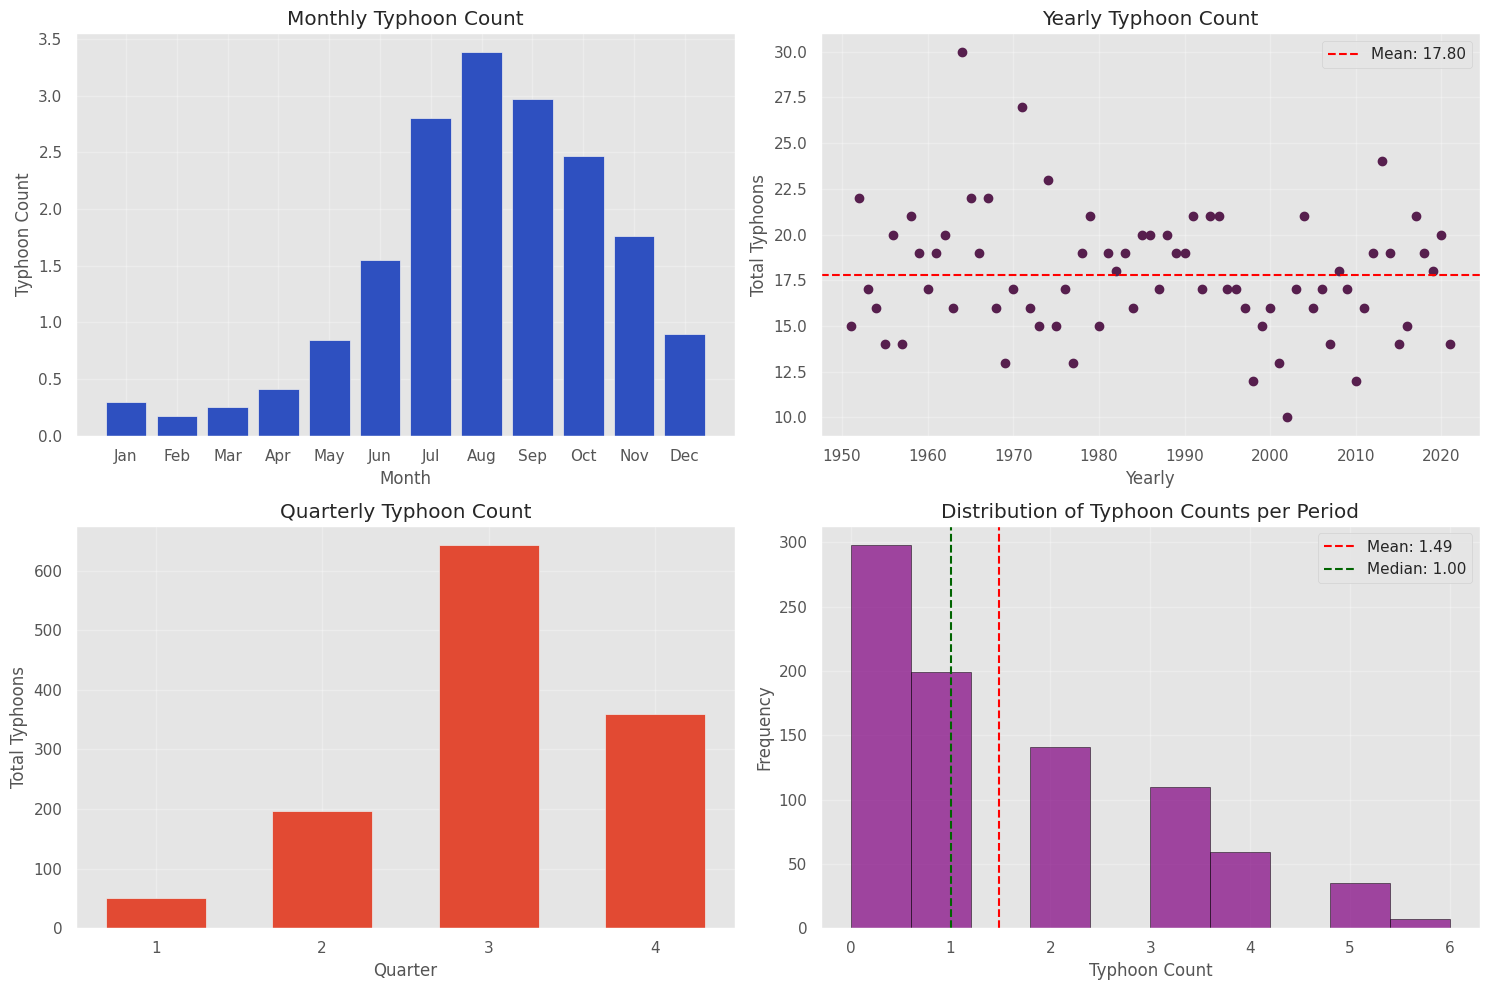

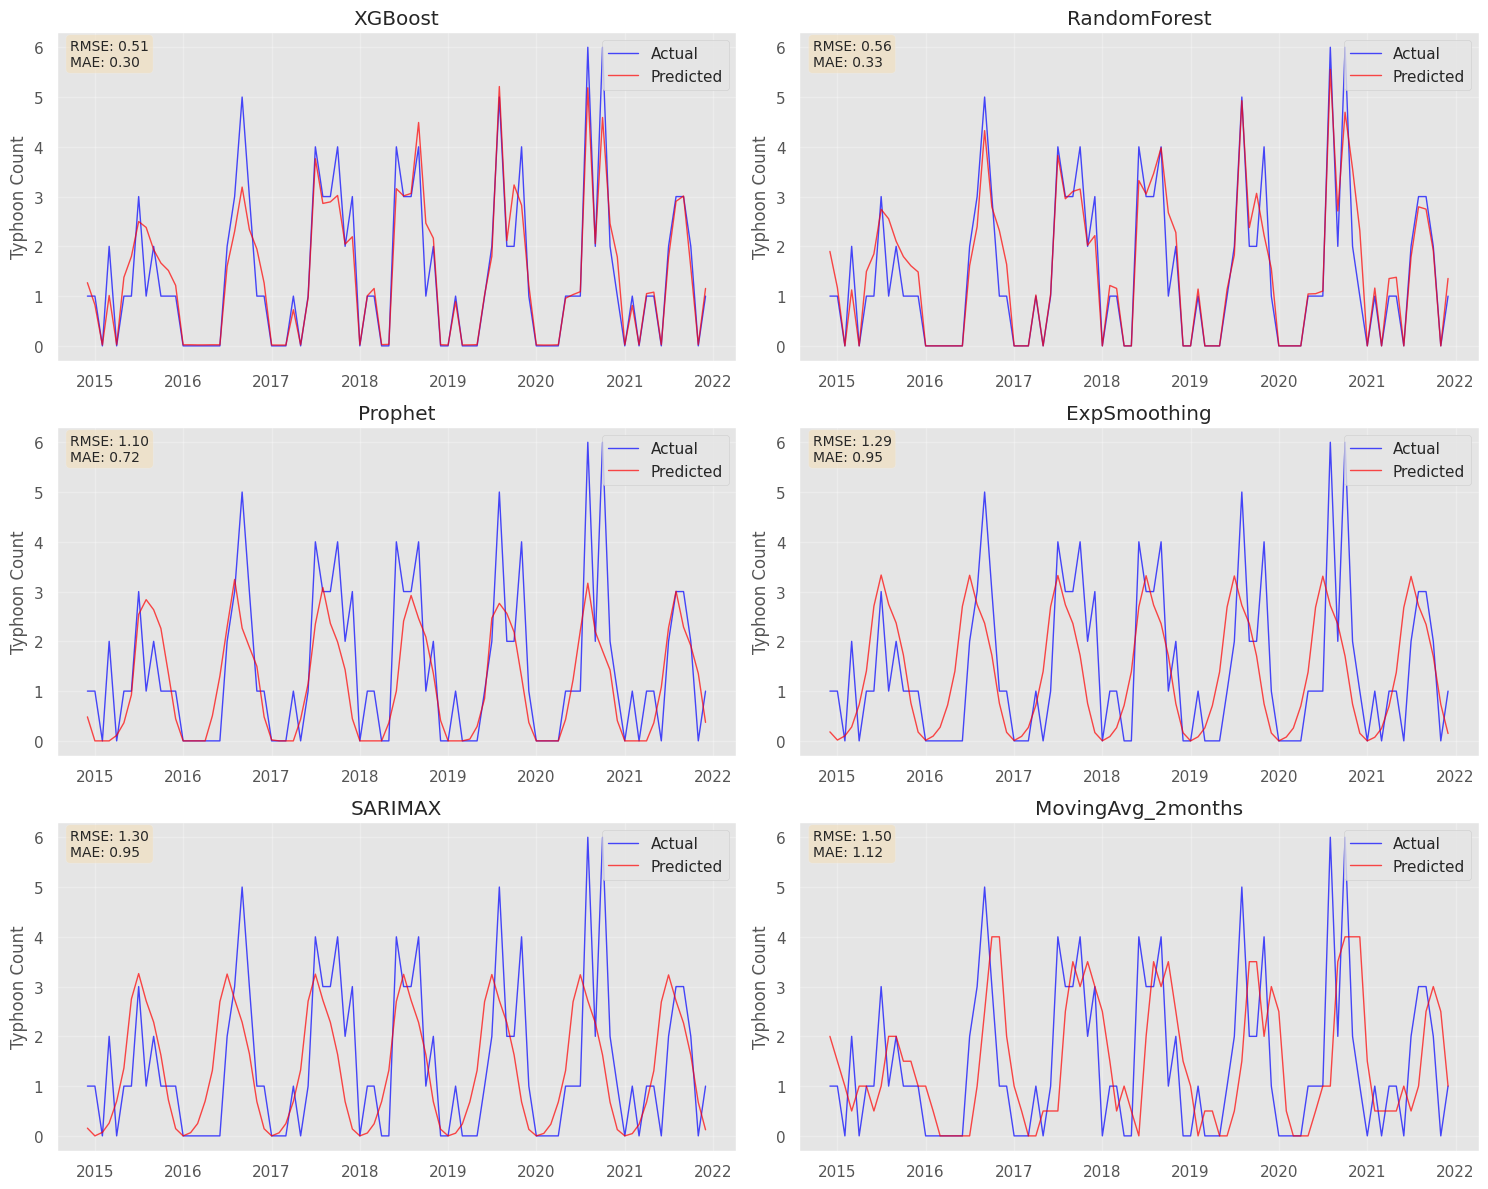

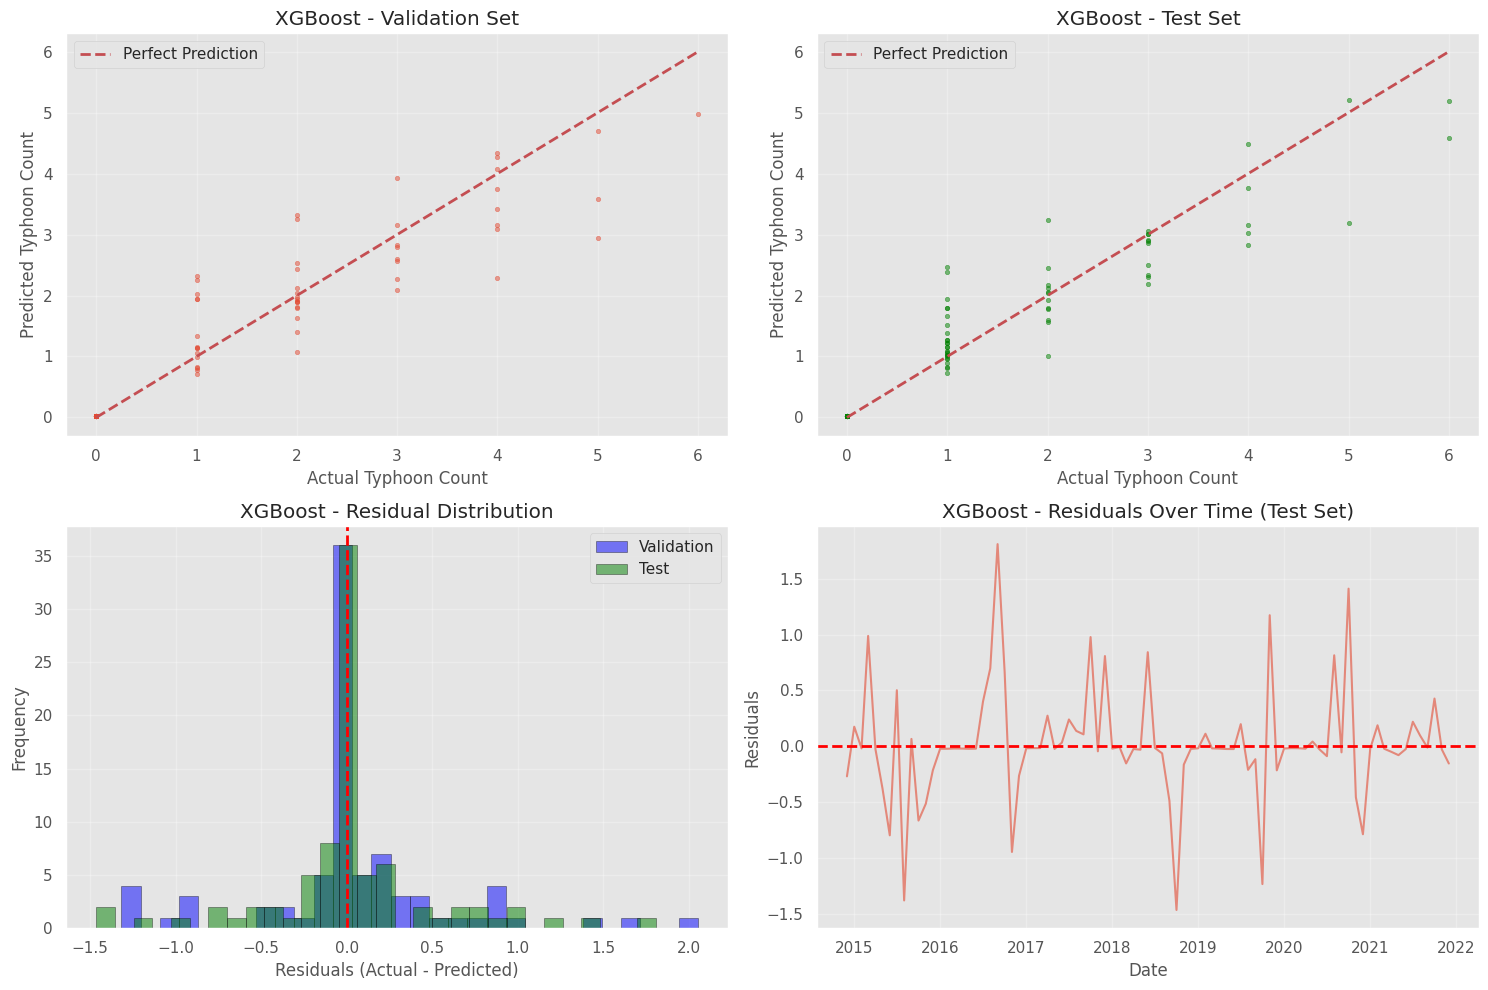

In [98]:
################################################################################
# Model Visualization (A lot of wrong things here)
################################################################################

print("\n9. CREATING VISUALIZATIONS")
print("-" * 50)

# Plot 1: Seasonal Pattern Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly pattern
monthly_avg = ts_data.groupby('month')['typhoon_count'].mean()
axes[0, 0].bar(range(1, 13), monthly_avg.values, color='#2E50C0')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Typhoon Count')
axes[0, 0].set_title('Monthly Typhoon Count')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0, 0].grid(True, alpha=0.3)

# Yearly trend
yearly_counts = ts_data.groupby('year')['typhoon_count'].sum()
axes[0, 1].scatter(yearly_counts.index, yearly_counts.values, marker='o', color='#571F4E',linewidth=1)
axes[0, 1].axhline(yearly_counts.values.mean(), color='red',
                   linestyle='--', label=f'Mean: {yearly_counts.values.mean():.2f}')
axes[0, 1].set_xlabel('Yearly')
axes[0, 1].set_ylabel('Total Typhoons')
axes[0, 1].set_title('Yearly Typhoon Count')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Quarterly trend
quarterly_counts = feature_df.groupby('quarter')['typhoon_count'].sum()
quarterly_counts = pd.DataFrame(quarterly_counts).reset_index()
print(quarterly_counts)
axes[1, 0].bar(quarterly_counts['quarter'],quarterly_counts['typhoon_count'],width=0.6)
axes[1, 0].set_xticks([1,2,3,4])
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Total Typhoons')
axes[1, 0].set_title('Quarterly Typhoon Count')
axes[1, 0].grid(True, alpha=0.3)

# Distribution of typhoon counts
axes[1, 1].hist(ts_data['typhoon_count'], bins=10, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Typhoon Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Typhoon Counts per Period')
axes[1, 1].axvline(ts_data['typhoon_count'].mean(), color='red',
                   linestyle='--', label=f'Mean: {ts_data["typhoon_count"].mean():.2f}')
axes[1, 1].axvline(ts_data['typhoon_count'].median(), color='darkgreen',
                   linestyle='--', label=f'Median: {ts_data["typhoon_count"].median():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('typhoon_patterns.png', dpi=100)
print("✓ Seasonal patterns saved as 'typhoon_patterns.png'")

# Plot 2: Model Performance Comparison
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Select top 6 models for visualization
top_6_models = test_df.head(6)['Model'].values

for idx, model_name in enumerate(top_6_models):
    ax = axes[idx]

    # Plot actual vs predicted for test set
    test_subset = test_data.index[:500]  # First 500 points for clarity
    actual_subset = y_test[:500]
    pred_subset = test_predictions[model_name][:500]

    ax.plot(test_subset, actual_subset, label='Actual', color='blue', alpha=0.7, linewidth=1)
    ax.plot(test_subset, pred_subset, label='Predicted', color='red', alpha=0.7, linewidth=1)
    if model_name == 'SeasonalNaive':
        ax.plot(test_subset, actual_subset, label='Actual', color='blue', alpha=0.7, linewidth=1)

    # Calculate and display metrics
    model_metrics = test_df[test_df['Model'] == model_name].iloc[0]

    ax.set_title(f'{model_name}')
    ax.set_ylabel('Typhoon Count')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    # Add metrics text
    metrics_text = f'RMSE: {model_metrics["RMSE"]:.2f}\nMAE: {model_metrics["MAE"]:.2f}'
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('model_performance.png', dpi=100)
print("✓ Model performance comparison saved as 'model_performance.png'")

# Plot 3: Best Model Detailed Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

best_pred_val = predictions[best_model]
best_pred_test = test_predictions[best_model]

# Validation set performance
axes[0, 0].scatter(y_val, best_pred_val, alpha=0.5, s=10)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Typhoon Count')
axes[0, 0].set_ylabel('Predicted Typhoon Count')
axes[0, 0].set_title(f'{best_model} - Validation Set')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test set performance
axes[0, 1].scatter(y_test, best_pred_test, alpha=0.5, s=10, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Typhoon Count')
axes[0, 1].set_ylabel('Predicted Typhoon Count')
axes[0, 1].set_title(f'{best_model} - Test Set')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
residuals_val = y_val - best_pred_val
residuals_test = y_test - best_pred_test

axes[1, 0].hist(residuals_val, bins=30, alpha=0.5, label='Validation', color='blue', edgecolor='black')
axes[1, 0].hist(residuals_test, bins=30, alpha=0.5, label='Test', color='green', edgecolor='black')
axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'{best_model} - Residual Distribution')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals over time
axes[1, 1].plot(test_data.index[:len(residuals_test)], residuals_test, alpha=0.6)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title(f'{best_model} - Residuals Over Time (Test Set)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_analysis.png', dpi=100)
print("✓ Best model analysis saved as 'best_model_analysis.png'")

In [99]:
################################################################################
# Future Forecasting
################################################################################

print("\n10. GENERATING FUTURE FORECASTS")
print("-" * 50)

# Generate 2 years ahead forecast using best model
forecast_horizon = 24  # 2 years * 12 months
last_date = test_data.index[-1]

all_future_predictions ={}
model_storage = models.copy()

for model_name, model_obj in model_storage.items():
  print(f"Generating {forecast_horizon} period ({forecast_horizon:.0f} months) forecast using {model_name}...")
  if model_name == 'XGBoost' and 'XGBoost' in model_storage:
      # Recursive forecasting for XGBoost
      future_predictions = []
      last_known = test_data.iloc[-1:].copy()

      for i in range(forecast_horizon):
          X_future = scaler_features.transform(last_known[feature_cols])
          pred = model_obj.predict(X_future)[0]
          future_predictions.append(pred)

          # Update features for next prediction
          # This is simplified - in practice you'd update all lag features properly
          for lag in [1,2,4,6]:
              if f'lag_{lag}' in last_known.columns:
                  if lag == 1:
                      last_known[f'lag_{lag}'] = pred
                  elif f'lag_{lag-1}' in last_known.columns:
                      last_known[f'lag_{lag}'] = last_known[f'lag_{lag-1}'].values[0]

          # Update temporal features
          next_time = last_known.index[0] + pd.DateOffset(months=1)
          last_known.index = [next_time]
          last_known['month'] = next_time.month
          last_known['quarter'] = next_time.quarter
          last_known['year'] = next_time.year

          # Update Rolling features
          last_known['month_sin'] = np.sin(2 * np.pi * last_known['year'] / 12)
          last_known['month_cos'] = np.cos(2 * np.pi * last_known['year'] / 12)
          last_known['quarter_sin'] = np.sin(2 * np.pi * last_known['year'] /4)
          last_known['quarter_cos'] = np.cos(2 * np.pi * last_known['year'] /4)
          last_known['half_year_sin'] = np.sin(2 * np.pi * last_known['year']/6)
          last_known['half_year_cos'] = np.cos(2 * np.pi * last_known['year']/6)
          last_known['year_sin'] = np.sin(2 * np.pi * last_known['year'])
          last_known['year_cos'] = np.cos(2 * np.pi * last_known['year'])


          # Binary features (have two versions - one for typhoon first existence count and one for typhoon persistence)

          # Typhoon first existence
          last_known['new_recorded_typ'] = (last_known['typhoon_count'] > 0).astype(int)
          last_known['new_typ_last_month'] = (last_known['lag_1'] > 0).astype(int)
          last_known['new_typ_last_quarter'] = (last_known['lag_4'] > 0).astype(int)
          last_known['new_typ_last_half_year'] = (last_known['lag_6'] > 0).astype(int)
          last_known['total_typ_last_6_months'] = (last_known['rolling_sum_6'] > 0).astype(int)
          last_known['total_typ_last_year'] = (last_known['rolling_sum_12'] > 0).astype(int)

          # Interaction features
          last_known['month_x_rolling_mean'] = last_known['month'] * last_known['rolling_mean_12']

  elif model_name == 'RandomForest' and 'RandomForest' in model_storage:
      # Recursive forecasting for XGBoost
      future_predictions = []
      last_known = test_data.iloc[-1:].copy()

      for i in range(forecast_horizon):
          X_future = scaler_features.transform(last_known[feature_cols])
          pred = model_obj.predict(X_future)[0]
          future_predictions.append(pred)

          # Update features for next prediction
          # This is simplified - in practice you'd update all lag features properly
          for lag in [1,2,4,6]:
              if f'lag_{lag}' in last_known.columns:
                  if lag == 1:
                      last_known[f'lag_{lag}'] = pred
                  elif f'lag_{lag-1}' in last_known.columns:
                      last_known[f'lag_{lag}'] = last_known[f'lag_{lag-1}'].values[0]

          # Update temporal features
          next_time = last_known.index[0] + pd.DateOffset(months=1)
          last_known.index = [next_time]
          last_known['month'] = next_time.month
          last_known['quarter'] = next_time.quarter
          last_known['year'] = next_time.year
          # Update Rolling features
          last_known['month_sin'] = np.sin(2 * np.pi * last_known['year'] / 12)
          last_known['month_cos'] = np.cos(2 * np.pi * last_known['year'] / 12)
          last_known['quarter_sin'] = np.sin(2 * np.pi * last_known['year'] /4)
          last_known['quarter_cos'] = np.cos(2 * np.pi * last_known['year'] /4)
          last_known['half_year_sin'] = np.sin(2 * np.pi * last_known['year']/6)
          last_known['half_year_cos'] = np.cos(2 * np.pi * last_known['year']/6)
          last_known['year_sin'] = np.sin(2 * np.pi * last_known['year'])
          last_known['year_cos'] = np.cos(2 * np.pi * last_known['year'])


          # Binary features (have two versions - one for typhoon first existence count and one for typhoon persistence)

          # Typhoon first existence
          last_known['new_recorded_typ'] = (last_known['typhoon_count'] > 0).astype(int)
          last_known['new_typ_last_month'] = (last_known['lag_1'] > 0).astype(int)
          last_known['new_typ_last_quarter'] = (last_known['lag_4'] > 0).astype(int)
          last_known['new_typ_last_half_year'] = (last_known['lag_6'] > 0).astype(int)
          last_known['total_typ_last_6_months'] = (last_known['rolling_sum_6'] > 0).astype(int)
          last_known['total_typ_last_year'] = (last_known['rolling_sum_12'] > 0).astype(int)

          # Interaction features
          last_known['month_x_rolling_mean'] = last_known['month'] * last_known['rolling_mean_12']

      print('RandomForest')


  elif model_name == 'SARIMAX' and 'SARIMAX' in model_storage:
      future_predictions = model_obj.forecast(steps=forecast_horizon)
      future_predictions = np.maximum(future_predictions, 0)
      print(f'SARIMAX')

  elif model_name == 'Prophet' and 'Prophet' in model_storage:
      future = model_obj.make_future_dataframe(
          periods=len(val_data) + len(test_data) + forecast_horizon,
          freq='MS'
      )
      forecast = model_obj.predict(future)
      future_predictions = forecast['yhat'].iloc[-forecast_horizon:].values
      future_predictions = np.maximum(future_predictions, 0)
      # Get prediction intervals
      lower_bound = forecast['yhat_lower'].iloc[-forecast_horizon:].values
      upper_bound = forecast['yhat_upper'].iloc[-forecast_horizon:].values
      print(f'Prophet')
  else:
      # Fallback to seasonal average
      future_predictions = np.full(forecast_horizon, test_data[target_col].mean())

  future_predictions = np.array(future_predictions)
  all_future_predictions[model_name] = future_predictions

print(f'All Future Predictions:{all_future_predictions}')




10. GENERATING FUTURE FORECASTS
--------------------------------------------------
Generating 24 period (24 months) forecast using SARIMAX...
SARIMAX
Generating 24 period (24 months) forecast using Prophet...
Prophet
Generating 24 period (24 months) forecast using XGBoost...
Generating 24 period (24 months) forecast using RandomForest...
RandomForest
Generating 24 period (24 months) forecast using ExpSmoothing...
All Future Predictions:{'SARIMAX': array([0.15491066, 0.        , 0.07042661, 0.25722836, 0.69606587,
       1.36235021, 2.74936618, 3.26082794, 2.71339122, 2.28515981,
       1.62181076, 0.72210681, 0.14521682, 0.        , 0.06500758,
       0.24817033, 0.69793974, 1.31528738, 2.69476397, 3.25169978,
       2.74264644, 2.28379572, 1.65285005, 0.68751645]), 'Prophet': array([0.        , 0.        , 0.        , 0.        , 0.28969239,
       0.92577399, 2.33324367, 2.84698554, 2.38479013, 2.01286053,
       1.28272698, 0.33358234, 0.        , 0.        , 0.        ,
       0. 

            typhoon_obs  typhoon_counts
2022-01-01            0               0
2022-02-01            0               0
2022-03-01            0               0
2022-04-01            2               2
2022-05-01            0               0

Forecast Summary:
  Period: 2022-01-01 to 2023-12-01
  Mean predicted typhoon count: 1.66
  Max predicted typhoon count: 2.44
  Periods with predicted typhoons: 24 (100.0%)

Forecast by month:
  Jan: Total=2.4, Average=1.19
  Feb: Total=2.0, Average=1.00
  Mar: Total=2.0, Average=0.99
  Apr: Total=2.0, Average=0.99
  May: Total=2.6, Average=1.32
  Jun: Total=3.9, Average=1.96
  Jul: Total=4.9, Average=2.43
  Aug: Total=4.7, Average=2.35
  Sep: Total=4.4, Average=2.21
  Oct: Total=4.0, Average=2.00
  Nov: Total=3.5, Average=1.76
  Dec: Total=3.3, Average=1.66

Forecast Summary:
  Period: 2022-01-01 to 2023-12-01
  Mean predicted typhoon count: 1.84
  Max predicted typhoon count: 2.53
  Periods with predicted typhoons: 24 (100.0%)

Forecast by month:


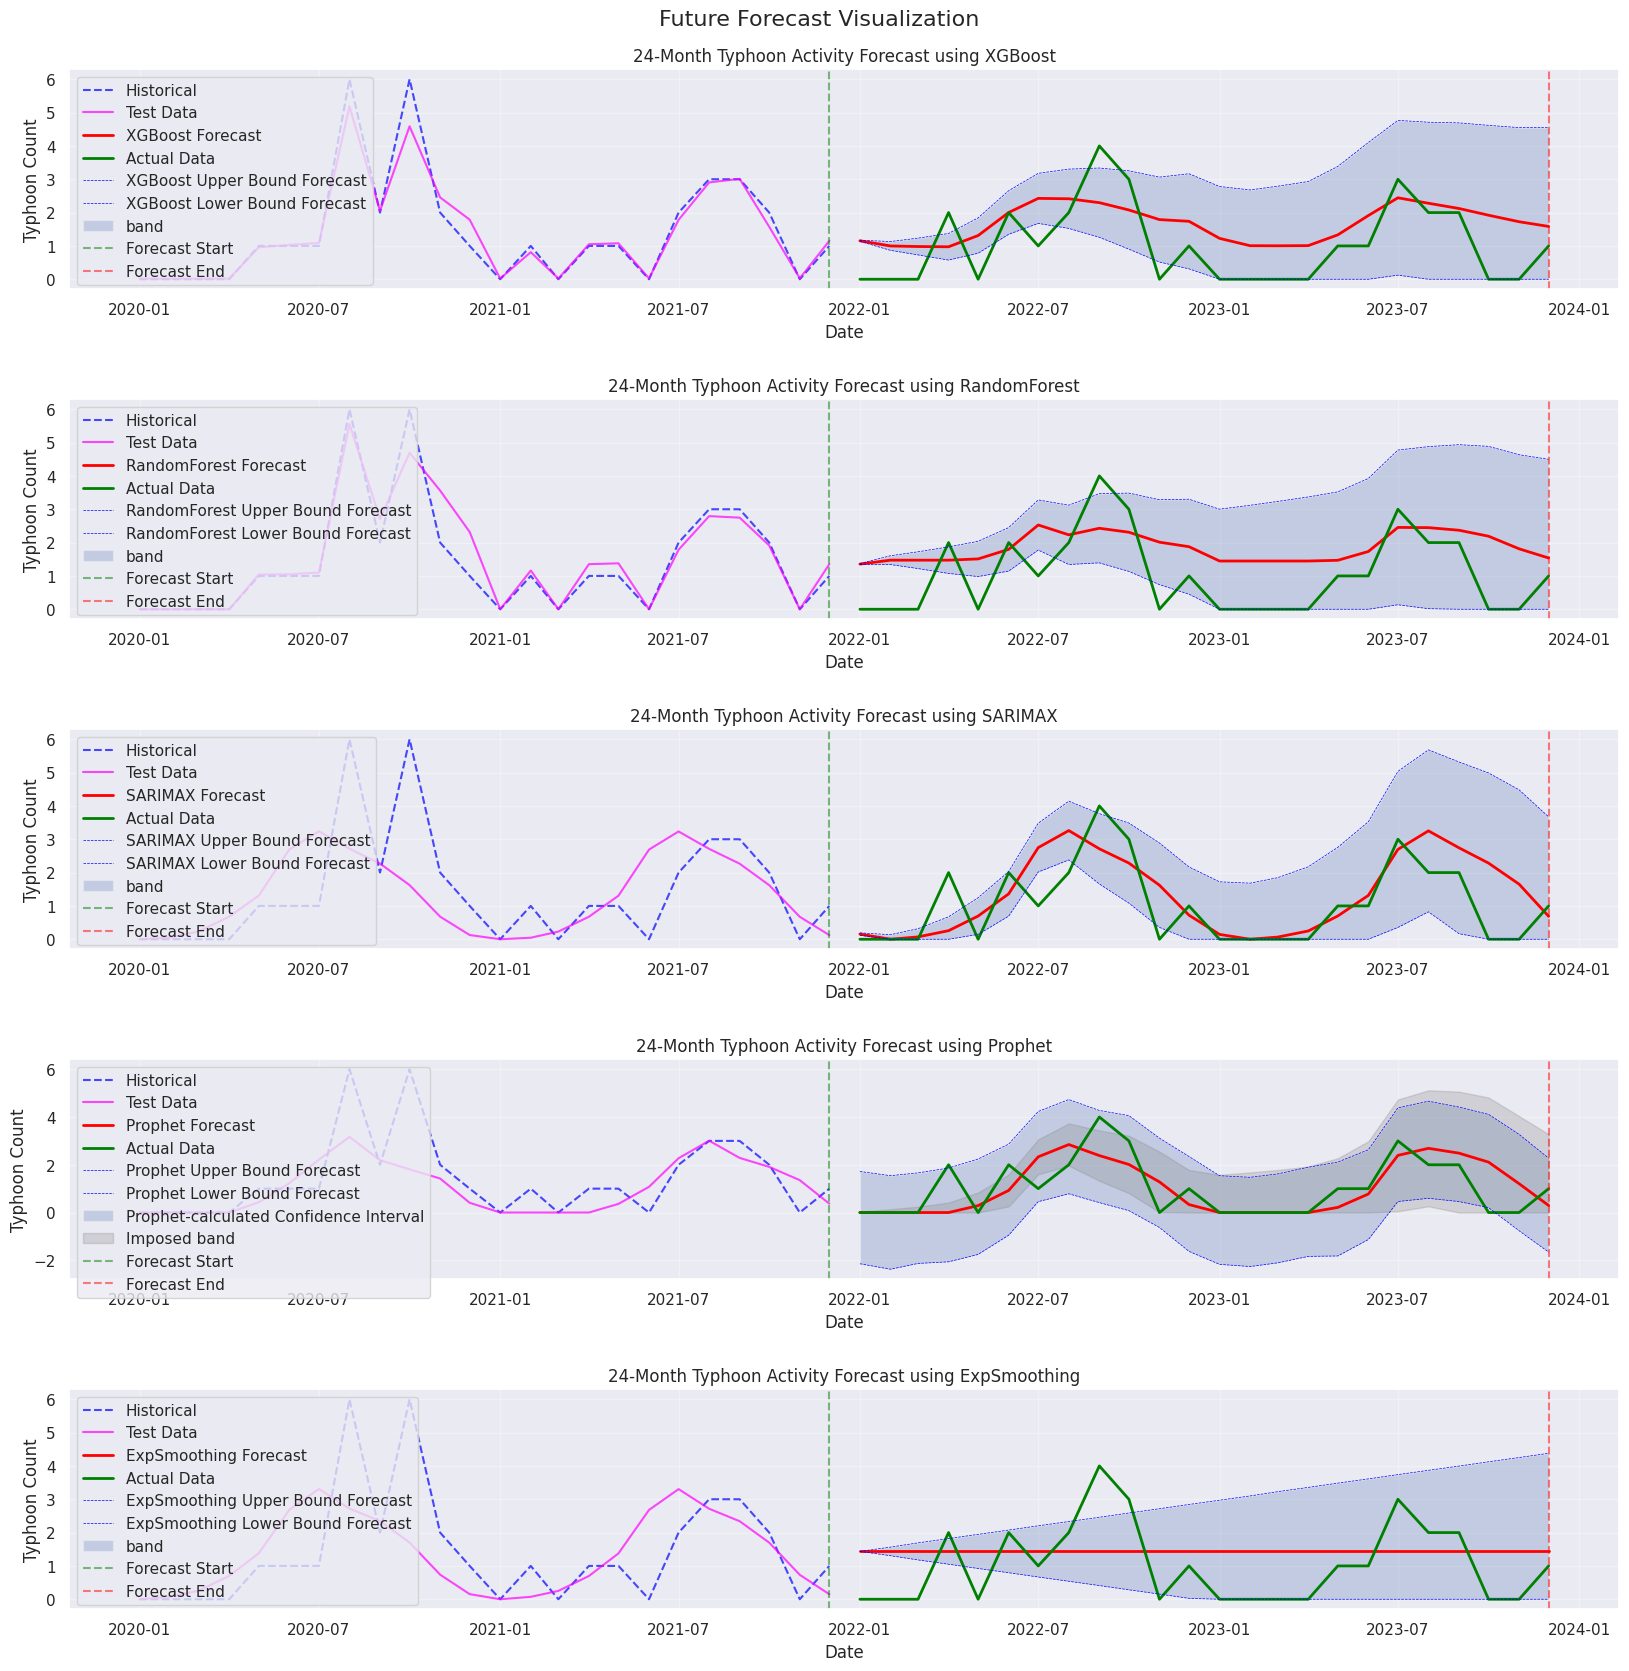

In [100]:
################################################################################
# Future Forecasting Visualization
################################################################################

# Create future dates
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                            periods=forecast_horizon, freq='MS')

# Show last 2 years of historical data
historical_periods = 24
historical_data = pd.concat([train_data, val_data, test_data])[target_col].iloc[-historical_periods:]

# Show next 2 years from the cutoff (actual data)
future_labeled_data = ts_data_s[ts_data_s.index.year > 2021]
print(future_labeled_data.head())

def calculate_imposed_prediction_interval(future_predictions,h = 1,T = 24,  K = 1, M = 1, coeff_1=0.80, scale_adj = 0.16):
    '''Generate an imposed prediction interval
        based on the standard deviation of the future predictions list.

      Parameters
      T: period of forecast
      h: step size (depending on the resolution of the time series data)
      K: number of adjustable parameters: set to 1
      M: number of missing values in the residuals: (set to 1 for naive forecast) - depending on the lag
      coeff_1: Adjustment in the amount of prediction interval (between 0 and 1)
      scale_adj: Adjustment in the amount of prediction interval (between 0 and 1)

    '''
    err = np.diff(future_predictions)
    err = np.flip(np.append(np.flip(err),0))
    std = np.sqrt((1/(T-K-M))*np.sum(err**2))
    std_drift = std*np.sqrt(h*(1+(h/T-1)))
    rng = np.random.default_rng(37)
    random_fluctuation = rng.normal(err.mean(), std, T).astype(float)
    std_drift_list = scale_adj*(coeff_1*np.array([i + std_drift for i in range(T)]).astype(float)+(1-coeff_1)*random_fluctuation)
    return std_drift_list

# Choose top models
all_top_models = ['XGBoost','RandomForest','SARIMAX','Prophet','ExpSmoothing']

sns.set_theme(style="darkgrid")

# Setup Forecasting Plots
fig_forecast, axes = plt.subplots(nrows = len(all_top_models), ncols = 1, figsize=(20, 20),gridspec_kw={'wspace':0.1, 'hspace':0.5})

fig_forecast.suptitle('Future Forecast Visualization', fontsize=16,y=0.91)
axes = axes.flatten()

for idx, model_name in enumerate(all_top_models):
    ax = axes[idx]
    pred_subset = test_predictions[model_name][len(test_predictions[model_name])-historical_periods:]

    future_predictions = all_future_predictions[model_name]

    ax.plot(historical_data.index, historical_data.values,
            label='Historical', color='blue', alpha=0.7, linewidth=1.5, linestyle = '--')
    ax.plot(historical_data.index, pred_subset,
            label='Test Data', color='magenta', alpha=0.7, linewidth=1.5)
    ax.plot(future_dates, future_predictions,
            label=f'{model_name} Forecast', color='red', linewidth=2)

    ax.plot(future_dates, future_labeled_data['typhoon_counts'],
            label=f'Actual Data', color='green', linewidth=2)

    std_drift_list = calculate_imposed_prediction_interval(future_predictions)

    # Filled Area
    if model_name == 'Prophet':
      ax.plot(future_dates, upper_bound, label=f'{model_name} Upper Bound Forecast', color='blue', linewidth=0.5,linestyle='--')

      ax.plot(future_dates, lower_bound,label=f'{model_name} Lower Bound Forecast', color='blue', linewidth=0.5,linestyle='--')

      ax.fill_between(future_dates, upper_bound, lower_bound, alpha=0.25, label='Prophet-calculated Confidence Interval')

      ax.fill_between(future_dates, future_predictions+std_drift_list, np.maximum((future_predictions-std_drift_list),0), alpha=0.25, label='Imposed band', color='grey')

    else:
      ax.plot(future_dates, future_predictions+std_drift_list, label=f'{model_name} Upper Bound Forecast', color='blue', linewidth=0.5,linestyle='--')

      ax.plot(future_dates, np.maximum((future_predictions-std_drift_list),0),label=f'{model_name} Lower Bound Forecast', color='blue', linewidth=0.5,linestyle='--')

      ax.fill_between(future_dates, future_predictions+std_drift_list, np.maximum((future_predictions-std_drift_list),0), alpha=0.25, label='band')

  # Mark the transition point
    ax.axvline(test_data.index[-1], color='green', linestyle='--',
           alpha=0.5, label='Forecast Start')
    ax.axvline(future_dates[-1], color='red', linestyle='--',
           alpha=0.5, label='Forecast End')

    ax.set_title(f'{forecast_horizon}-Month Typhoon Activity Forecast using {model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Typhoon Count')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Analyze forecast
    forecast_df = pd.DataFrame({
        'date': future_dates,
        'forecast': future_predictions
    })

    # Add temporal features for analysis
    forecast_df['month'] = forecast_df['date'].dt.month

    print(f"\nForecast Summary:")
    print(f"  Period: {future_dates[0].date()} to {future_dates[-1].date()}")
    print(f"  Mean predicted typhoon count: {future_predictions.mean():.2f}")
    print(f"  Max predicted typhoon count: {future_predictions.max():.2f}")
    print(f"  Periods with predicted typhoons: {(future_predictions > 0.5).sum()} ({(future_predictions > 0.5).mean()*100:.1f}%)")

    # Monthly breakdown of forecast
    monthly_forecast = forecast_df.groupby('month')['forecast'].agg(['mean', 'sum'])
    print(f"\nForecast by month:")
    for month, row in monthly_forecast.iterrows():
        month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][month-1]
        print(f"  {month_name}: Total={row['sum']:.1f}, Average={row['mean']:.2f}")

fig_forecast.savefig('all_model_future_forecast.png', dpi=300)
print("✓ Future forecast saved as 'all_model_future_forecast.png'")




✓ Future forecast saved as 'all_in_one_future_forecast.png'


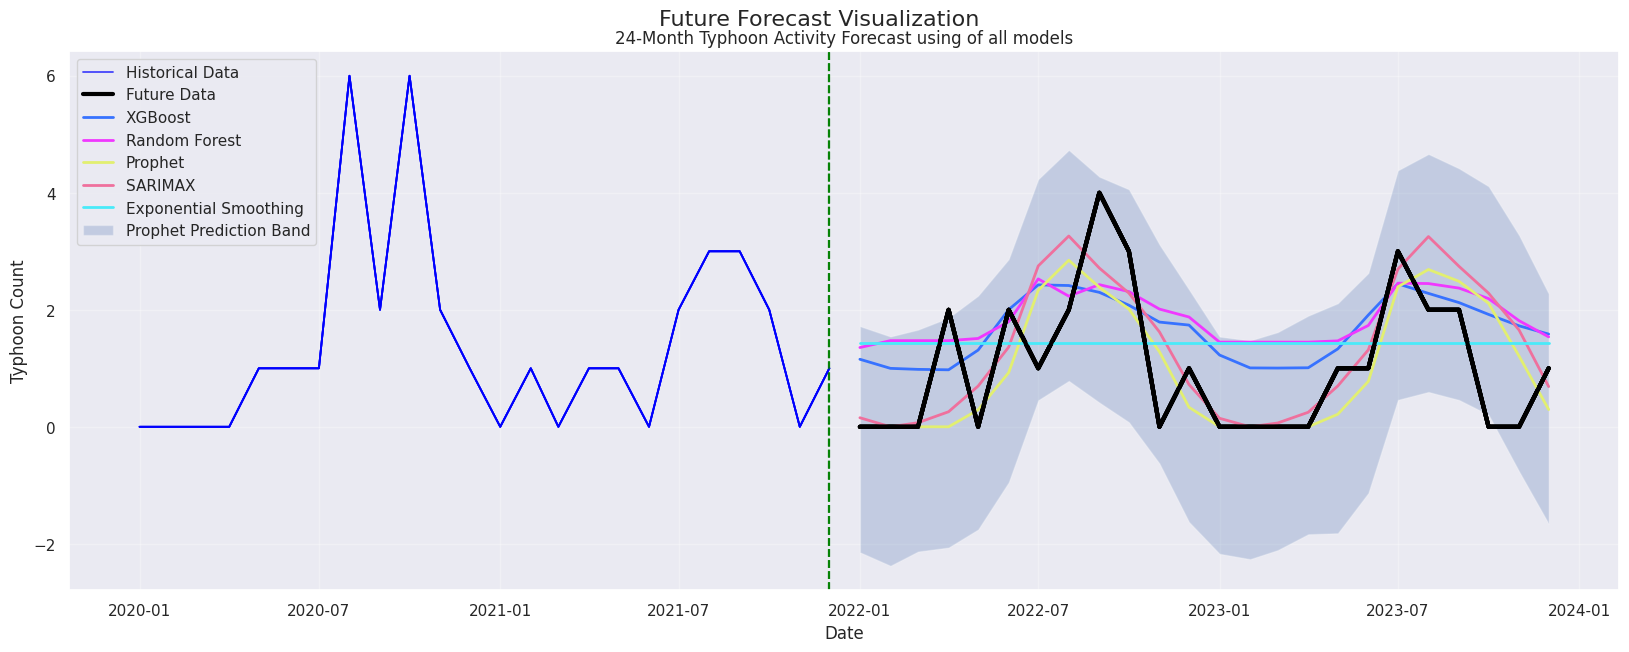

In [126]:
# All-in-one Forecast Plot:
# Choose top models
all_top_models = ['XGBoost','RandomForest','SARIMAX','Prophet','ExpSmoothing']

sns.set_theme(style="darkgrid")

c3_palette = ['#3772FF','#F038FF','#EF709D','#E2EF70','#49EAF9']

# Setup Forecasting Plots
fig_forecast, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 7),gridspec_kw={'wspace':0.1, 'hspace':0.5})

fig_forecast.suptitle('Future Forecast Visualization', fontsize=16,y=0.94)

for idx, model_name in enumerate(all_top_models):
    pred_subset = test_predictions[model_name][len(test_predictions[model_name])-historical_periods:]

    future_predictions = all_future_predictions[model_name]

    ax.plot(historical_data.index, historical_data.values,
            label='Historical', color='blue', alpha=0.7, linewidth=1.3, linestyle = '-')

    ax.plot(future_dates, future_predictions,
            label=f'{model_name} Forecast', color=c3_palette[idx], linewidth=2,linestyle = '-')

    ax.plot(future_dates, future_labeled_data['typhoon_counts'],
            label=f'Actual Data', color='black', linewidth=3)

    std_drift_list = calculate_imposed_prediction_interval(future_predictions)

    # Filled Area
    if model_name == 'Prophet':
      ax.fill_between(future_dates, upper_bound, lower_bound, alpha=0.25, label = 'Prophet Calculated Prediction Interval')


  # Mark the transition point
    ax.axvline(test_data.index[-1], color='green', linestyle='--',
           alpha=0.5)

    ax.set_title(f'{forecast_horizon}-Month Typhoon Activity Forecast using of all models')
    ax.set_xlabel('Date')
    ax.set_ylabel('Typhoon Count')
    ax.grid(True, alpha=0.3)
    ax.legend()

handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))          # later duplicates overwritten; use reversed(...) for first wins
ax.legend(uniq.values(), uniq.keys())

rename = {'Historical':'Historical Data',
          'Actual Data':'Future Data',
          'XGBoost Forecast':'XGBoost',
          'RandomForest Forecast':'Random Forest',
          'Prophet Forecast':'Prophet',
          'SARIMAX Forecast': 'SARIMAX',
          'ExpSmoothing Forecast':'Exponential Smoothing',
          'Prophet Calculated Prediction Interval': 'Prophet Prediction Band'}

order = ['Historical','Actual Data','XGBoost Forecast','RandomForest Forecast','Prophet Forecast','SARIMAX Forecast','ExpSmoothing Forecast','Prophet Calculated Prediction Interval']

sel = {l: h for h, l in zip(handles, labels) if l in order}
ax.legend([sel[k] for k in order], [rename.get(k, k) for k in order], loc='upper left')

fig_forecast.show()
fig_forecast.savefig('all_in_one_future_forecast.png', dpi=300)
print("✓ Future forecast saved as 'all_in_one_future_forecast.png'")

In [101]:
#################################################################
# Model Saving
#################################################################
print(models.keys())

if 'XGBoost' in models:
    models['XGBoost'].save_model('xgboost_model.json')
if 'RandomForest' in models:
    from joblib import dump, load
    dump(models['RandomForest'],'randomforest_model.json')
if 'SARIMAX' in models:
    models['SARIMAX'].save('sarimax_model.json')
if 'Prophet' in models:
    from prophet.serialize import model_to_json, model_from_json
    with open("prophet.json", "w") as f:
      json.dump(model_to_json(models['Prophet']), f)
if 'ExpSmoothing' in models:
    models['ExpSmoothing'].save('exp_smoothing_model.json')

dict_keys(['SARIMAX', 'Prophet', 'XGBoost', 'RandomForest', 'ExpSmoothing'])


In [102]:
# ============================================================================
# SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE - SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

print("\n📊 DATASET CHARACTERISTICS:")
print(f"  • Time span: {ts_data.index.min().year} to {ts_data.index.max().year}")
print(f"  • Total observations: {len(ts_data):,}")
print(f"  • Observation frequency: 1 month")
print(f"  • Active typhoon periods: {(ts_data['typhoon_count'] > 0).sum():,} ({(ts_data['typhoon_count'] > 0).mean()*100:.1f}%)")

print("\n🌀 TYPHOON PATTERNS:")
peak_months_names = [['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][m-1]
                     for m in peak_months]
print(f"  • Peak season: {', '.join(peak_months_names)}")
print(f"  • Average typhoons when active: {ts_data[ts_data['typhoon_count'] > 0]['typhoon_count'].mean():.2f}")
print(f"  • Maximum simultaneous typhoons: {ts_data['typhoon_count'].max()}")

print("\n🏆 MODEL PERFORMANCE RANKING:")
for i, row in test_df.head(5).iterrows():
    print(f"  {i+1}. {row['Model']}: RMSE={row['RMSE']:.3f}, MAE={row['MAE']:.3f}")

print("\n💡 KEY INSIGHTS:")
print(f"  1. {best_model} performs best with RMSE of {best_rmse:.3f}")
print(f"  2. Typhoon activity shows clear seasonal patterns")
print(f"  3. Recent historical patterns (lag features) are strong predictors")

if 'XGBoost' in model_details and 'top_features' in model_details['XGBoost']:
    print(f"\n📈 MOST IMPORTANT PREDICTIVE FEATURES:")
    for i, row in model_details['XGBoost']['top_features'].head(5).iterrows():
        print(f"  • {row['feature']}: {row['importance']:.3f}")

print("\n🔮 FORECAST OUTLOOK:")
print(f"  • Next 30 days: Average {future_predictions.mean():.2f} typhoons per month period")
print(f"  • Peak activity expected: {future_dates[future_predictions.argmax()].date()}")
print(f"  • Probability of typhoon activity: {(future_predictions > 0.5).mean()*100:.1f}%")

print("\n📁 OUTPUT FILES:")
print("  • typhoon_decomposition.png - Time series decomposition")
print("  • typhoon_patterns.png - Seasonal and temporal patterns")
print("  • model_performance.png - Model comparison visualizations")
print("  • best_model_analysis.png - Detailed analysis of best model")
print("  • future_forecast.png - 30-day forecast visualization")

print("\n" + "=" * 70)
print("END OF ANALYSIS")
print("=" * 70)


ANALYSIS COMPLETE - SUMMARY AND RECOMMENDATIONS

📊 DATASET CHARACTERISTICS:
  • Time span: 1951 to 2021
  • Total observations: 849
  • Observation frequency: 1 month
  • Active typhoon periods: 551 (64.9%)

🌀 TYPHOON PATTERNS:
  • Peak season: Aug, Sep, Jul
  • Average typhoons when active: 2.29
  • Maximum simultaneous typhoons: 6.0

🏆 MODEL PERFORMANCE RANKING:
  3. XGBoost: RMSE=0.507, MAE=0.298
  4. RandomForest: RMSE=0.558, MAE=0.333
  2. Prophet: RMSE=1.100, MAE=0.717
  5. ExpSmoothing: RMSE=1.293, MAE=0.953
  1. SARIMAX: RMSE=1.300, MAE=0.950

💡 KEY INSIGHTS:
  1. XGBoost performs best with RMSE of 0.507
  2. Typhoon activity shows clear seasonal patterns
  3. Recent historical patterns (lag features) are strong predictors

📈 MOST IMPORTANT PREDICTIVE FEATURES:
  • new_recorded_typ: 0.736
  • month: 0.052
  • quarter: 0.030
  • rolling_max_6: 0.028
  • rolling_std_6: 0.020

🔮 FORECAST OUTLOOK:
  • Next 30 days: Average 1.44 typhoons per month period
  • Peak activity expected: